<h1>Import Lib</h1>

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

In [74]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import skew  # for some statistics
from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


In [75]:
df = pd.read_csv('/content/drive/My Drive/MY ML JOURNEY/NoteBook/Datasets /House Price/train.csv')
dt = pd.read_csv('/content/drive/My Drive/MY ML JOURNEY/NoteBook/Datasets /House Price/test.csv')
test_dataY = pd.read_csv('/content/drive/My Drive/MY ML JOURNEY/NoteBook/Datasets /House Price/sample_submission.csv')

<h1>Remove Outlier</h1>

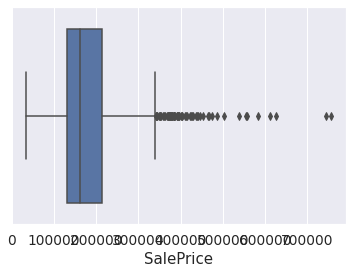

In [76]:
sns.boxplot(x=df['SalePrice'])

In [77]:
df = df[df.SalePrice < 350000]
df.reset_index(drop=True, inplace=True)
df.shape

(1404, 81)

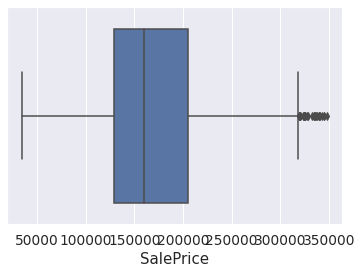

In [78]:
sns.boxplot(x=df['SalePrice'])

In [79]:
(((df.isnull().sum())*100)/len(df)).sort_values(
            ascending = False, kind = 'mergesort').head(15)

PoolQC          99.572650
MiscFeature     96.153846
Alley           93.518519
Fence           80.199430
FireplaceQu     49.145299
LotFrontage     18.233618
GarageCond       5.769231
GarageQual       5.769231
GarageFinish     5.769231
GarageYrBlt      5.769231
GarageType       5.769231
BsmtFinType2     2.706553
BsmtExposure     2.706553
BsmtFinType1     2.635328
BsmtCond         2.635328
dtype: float64

In [80]:
(((dt.isnull().sum())*100)/len(dt)).sort_values(
            ascending = False, kind = 'mergesort').head(30)

PoolQC          99.794380
MiscFeature     96.504455
Alley           92.666210
Fence           80.123372
FireplaceQu     50.034270
LotFrontage     15.558602
GarageCond       5.346127
GarageQual       5.346127
GarageFinish     5.346127
GarageYrBlt      5.346127
GarageType       5.209047
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtQual         3.015764
BsmtFinType2     2.878684
BsmtFinType1     2.878684
MasVnrType       1.096642
MasVnrArea       1.028101
MSZoning         0.274160
Functional       0.137080
BsmtHalfBath     0.137080
BsmtFullBath     0.137080
Utilities        0.137080
SaleType         0.068540
GarageArea       0.068540
GarageCars       0.068540
KitchenQual      0.068540
TotalBsmtSF      0.068540
BsmtUnfSF        0.068540
BsmtFinSF2       0.068540
dtype: float64

In [81]:
df.drop(['Id','PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)
dt.drop(['Id','PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)

<h1>Replace null using mean and mode</h1>

In [82]:
y = df['SalePrice']
df.drop(['SalePrice'], axis = 1, inplace = True)
data = pd.concat([df,dt], axis = 0)
data.shape

(2863, 75)

In [83]:
year_all = ['YearBuilt', 'YearRemodAdd','YrSold','MoSold','GarageYrBlt']
for i in data:
  if (data[i].dtypes == object and i != 'FireplaceQu') or i in year_all:
    data[i] = data[i].fillna(data[i].mode()[0])

In [84]:
data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0])
data['BsmtFullBath'] = data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0])
data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mode()[0])

In [85]:
for i in data:
  if data[i].dtypes != object:
     data[i] = data[i].fillna(data[i].mean())
     data[i] = data[i].astype('float64')

<h1>Replace null value of ''FireplaceQu'' using classification</h1>

In [86]:

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.01, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(ccp_alpha=0.0,max_depth=20, n_estimators=2500),
    GaussianNB(),
    GradientBoostingClassifier(learning_rate=0.03),
    AdaBoostClassifier(learning_rate=0.6)]
#Using only numerical features
fireplace_data = data.select_dtypes(exclude=['object'])
fireplace_data['FireplaceQu'] = data['FireplaceQu'].copy()

def classify_missing(all_int_dataTe):
  fire_train = pd.DataFrame()
  fire_test = pd.DataFrame()
  null_row_list = list(all_int_dataTe[all_int_dataTe['FireplaceQu'].isnull()].index.tolist())
  col = list(all_int_dataTe.columns)
  k = -1
  for j in null_row_list:
    try:
      k+=1 
      null_row_value = all_int_dataTe.iloc[j]
      null_row_value = list(null_row_value.values)
      for i in range(len(null_row_value)):
        fire_test.loc[k,col[i]] = null_row_value[i]
    except:
      continue
  fire_train = all_int_dataTe.dropna()
  fire_test = fire_test.drop(['FireplaceQu'],axis = 1)

  f_train = fire_train.drop(['FireplaceQu'],axis = 1)
  y_train = fire_train['FireplaceQu']

  
  le = preprocessing.LabelEncoder()
  le.fit(y_train)
  y_train = le.transform(y_train)

  
  X_train, X_test, y_train, y_test = train_test_split(f_train, y_train, test_size=0.1, random_state=1)
  r = 0
  for clf in classifiers:
    clf.fit(X_train,y_train)
    print(clf.__class__.__name__,' ', round(clf.score(X_test, y_test) * 100, 2))
    if r < clf.score(X_test, y_test):
      r = clf.score(X_test, y_test)
      model = clf
  print(model)
  model.fit(X_train,y_train)
  Y_prediction = model.predict(fire_test)
  res = le.inverse_transform(Y_prediction)

  for i in range(len(null_row_list)):
    try:
      all_int_dataTe.loc[null_row_list[i],'FireplaceQu'] = res[i]
    except:
      print('error')
  return all_int_dataTe['FireplaceQu']
data['FireplaceQu'] = classify_missing(fireplace_data)

LogisticRegression   55.86
KNeighborsClassifier   47.59
SVC   44.14
DecisionTreeClassifier   60.0
RandomForestClassifier   69.66
GaussianNB   11.72
GradientBoostingClassifier   68.97
AdaBoostClassifier   41.38
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [87]:
(((data.isnull().sum())*100)/len(data)).sort_values(
            ascending = False, kind = 'mergesort').head(15)

SaleCondition    0.0
SaleType         0.0
YrSold           0.0
MoSold           0.0
MiscVal          0.0
PoolArea         0.0
ScreenPorch      0.0
3SsnPorch        0.0
EnclosedPorch    0.0
OpenPorchSF      0.0
WoodDeckSF       0.0
PavedDrive       0.0
GarageCond       0.0
GarageQual       0.0
GarageArea       0.0
dtype: float64

<h1> Categorical Data Visualization<h1>


In [88]:
cat_data = []
for i in data:
  if len(data[i].unique()) <=10:
    cat_data.append(i)

In [89]:
len(cat_data)

47

In [90]:
tx = data.iloc[:len(y), :]
ty = data.iloc[len(tx):, :]
tx['SalePrice'] = y.copy()

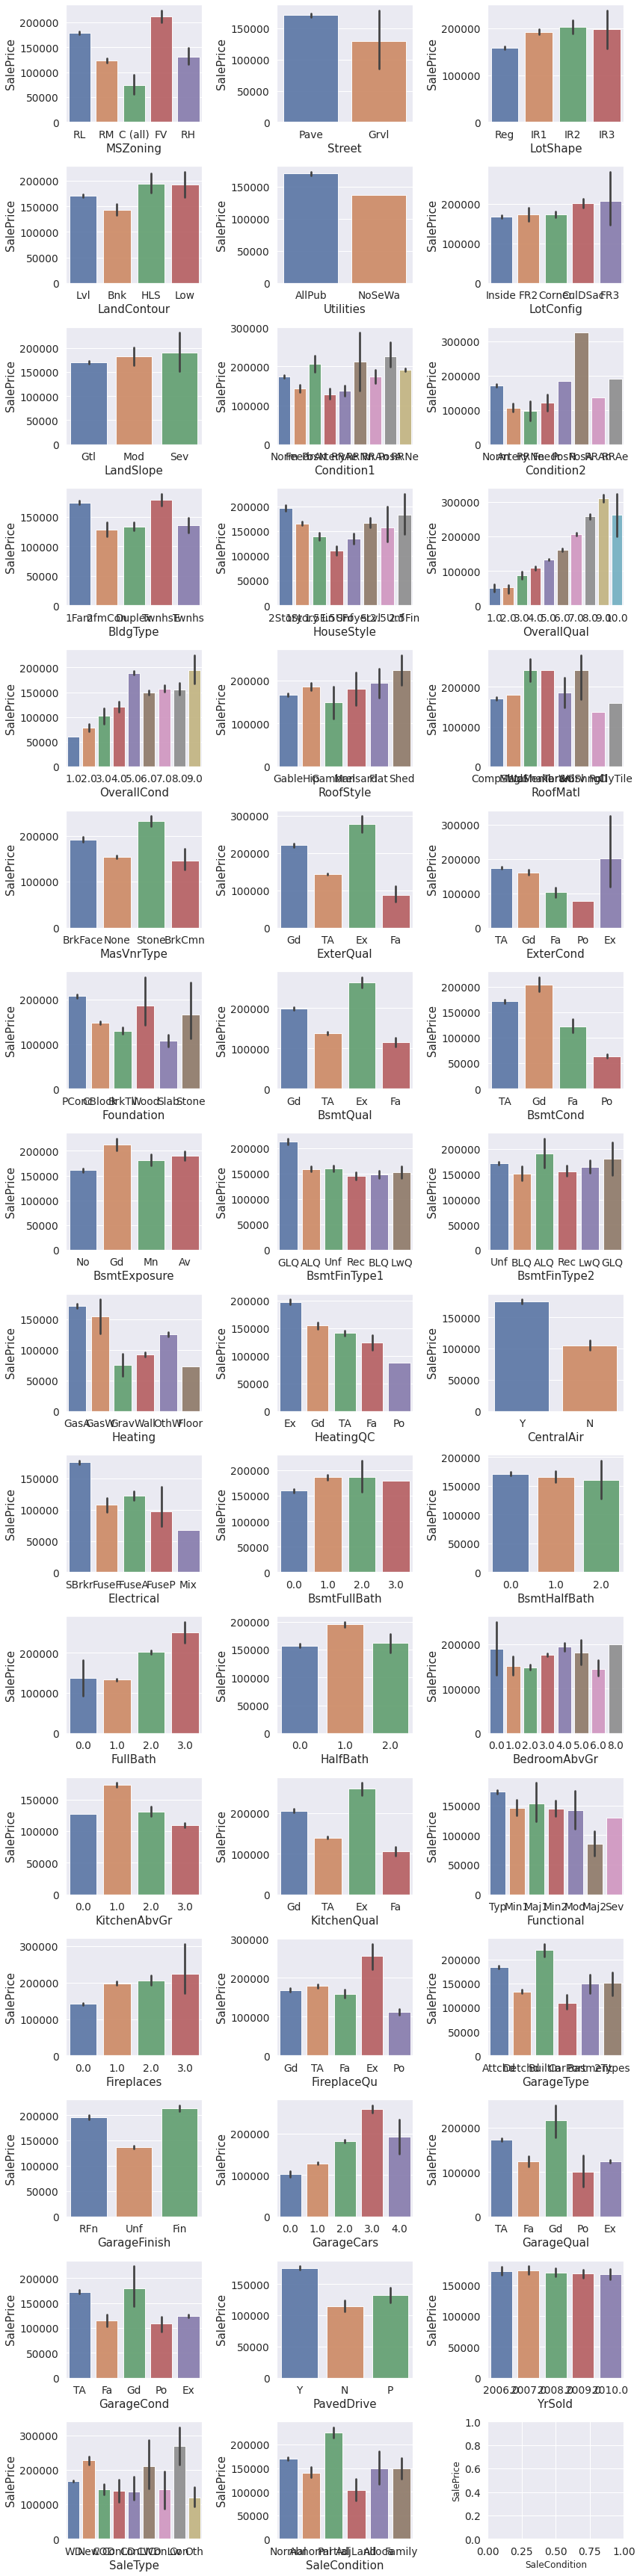

In [91]:
nr_rows = 16
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
i = 0
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
      if i< len(cat_data):
        x = tx[cat_data[i]]
        sns.barplot(x, y, alpha=0.9,ax = axs[r][c])
        plt.ylabel('SalePrice', fontsize=12)
        plt.xlabel(cat_data[i], fontsize=12)
        i+=1
plt.tight_layout()    
plt.show()

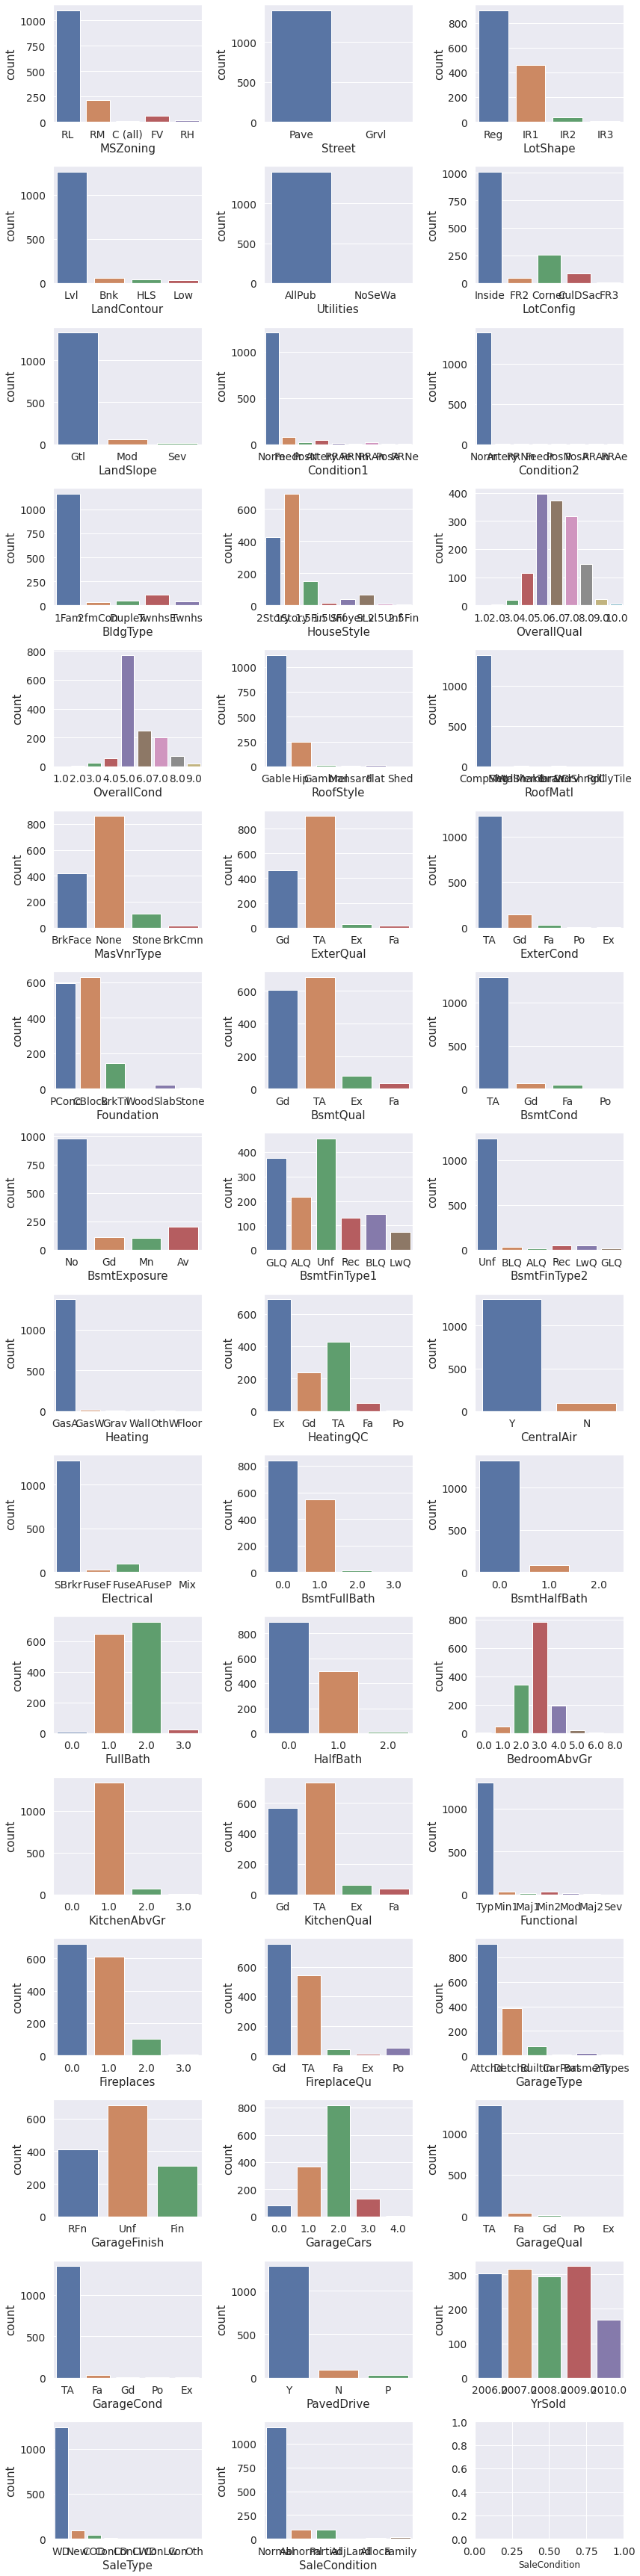

In [92]:
nr_rows = 16
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
i = 0
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
      if i< len(cat_data):
        x = tx[cat_data[i]]
        sns.countplot(x, data = tx, ax = axs[r][c])
        #plt.ylabel('SalePrice', fontsize=12)
        plt.xlabel(cat_data[i], fontsize=12)
        i+=1
plt.tight_layout()    
plt.show()

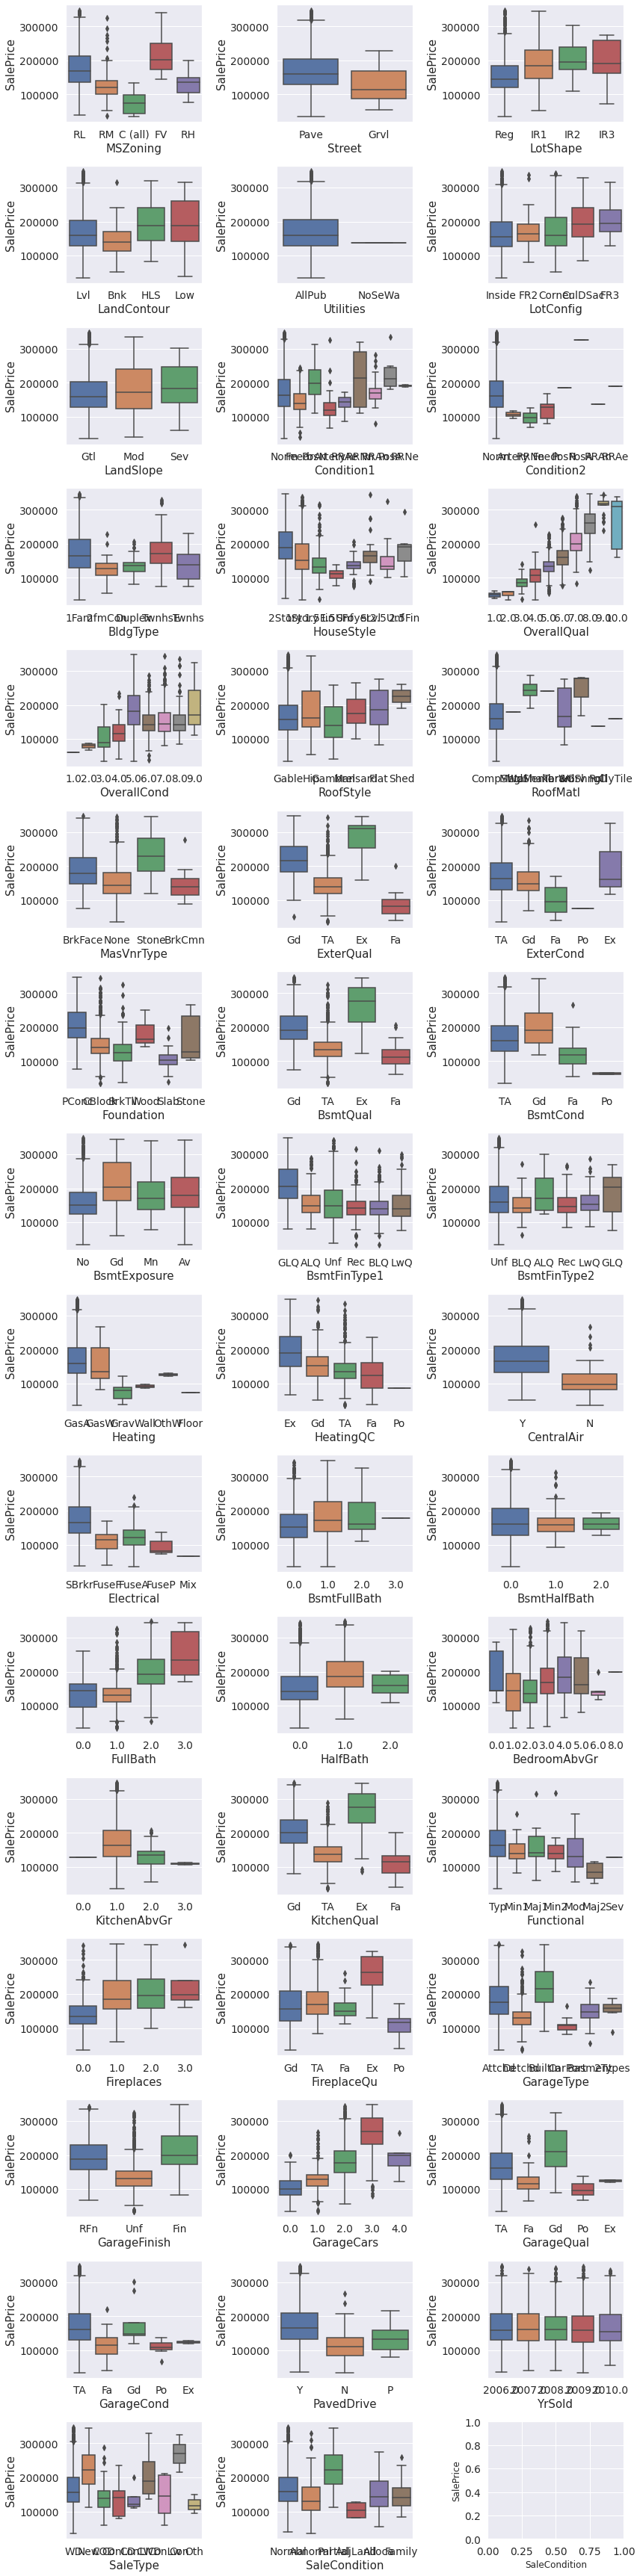

In [93]:
nr_rows = 16
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
i = 0
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
      if i< len(cat_data):
        sns.boxplot(x=tx[cat_data[i]], y = y, data=df, ax = axs[r][c])
        plt.ylabel('SalePrice', fontsize=12)
        plt.xlabel(cat_data[i], fontsize=12)
        i+=1
plt.tight_layout()    
plt.show()

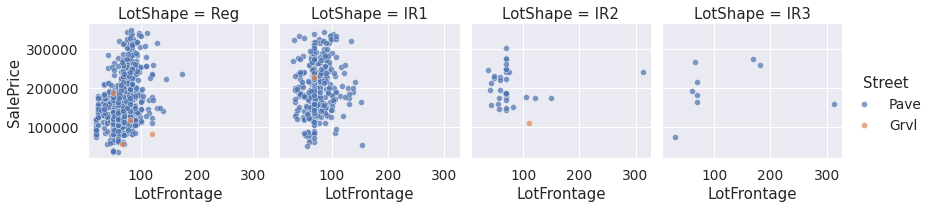

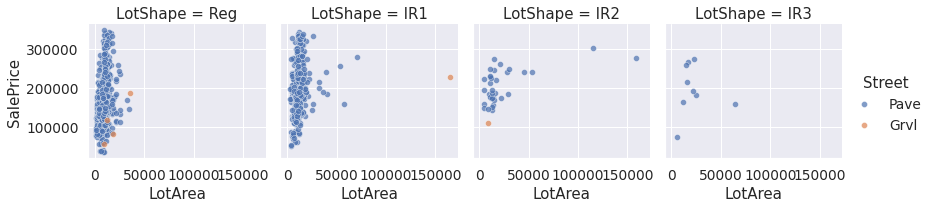

In [94]:
g = sns.FacetGrid(tx, col="LotShape", hue="Street")
g.map(sns.scatterplot, "LotFrontage", "SalePrice", alpha=.7)
g.add_legend()
#g.fig.subplots_adjust(wspace=.1, hspace=.1 )

g = sns.FacetGrid(tx, col="LotShape", hue="Street" )
g.map(sns.scatterplot, "LotArea", "SalePrice", alpha=.7  )
g.add_legend()

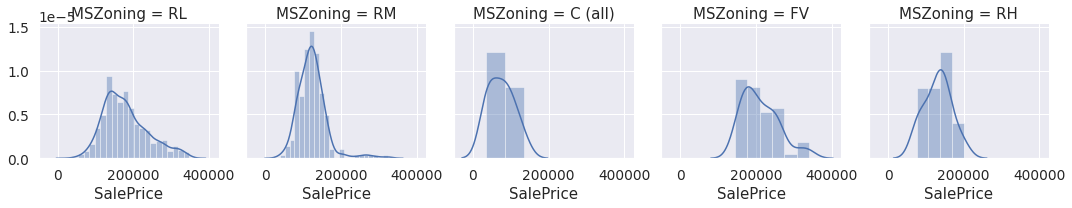

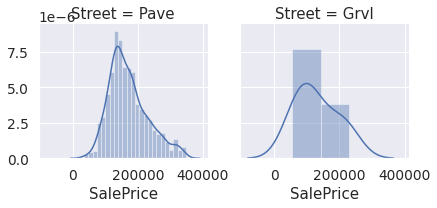

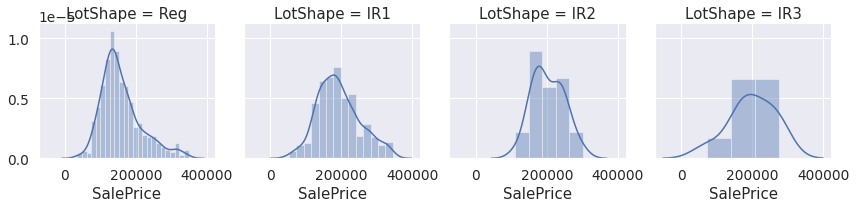

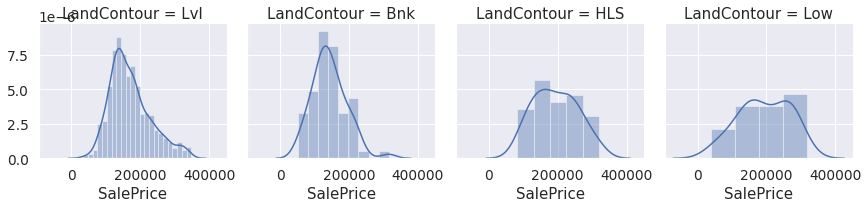

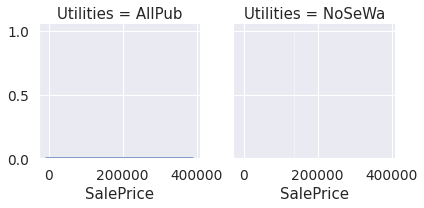

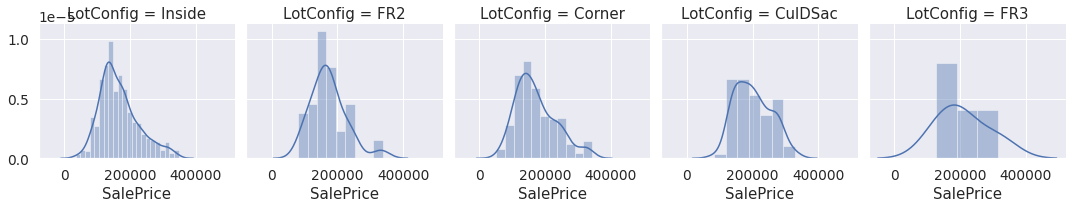

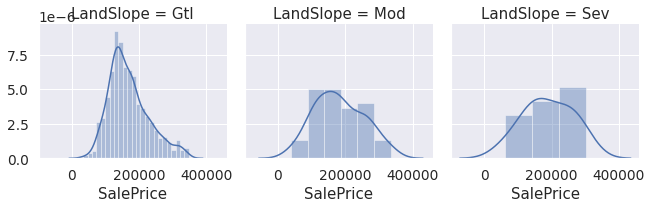

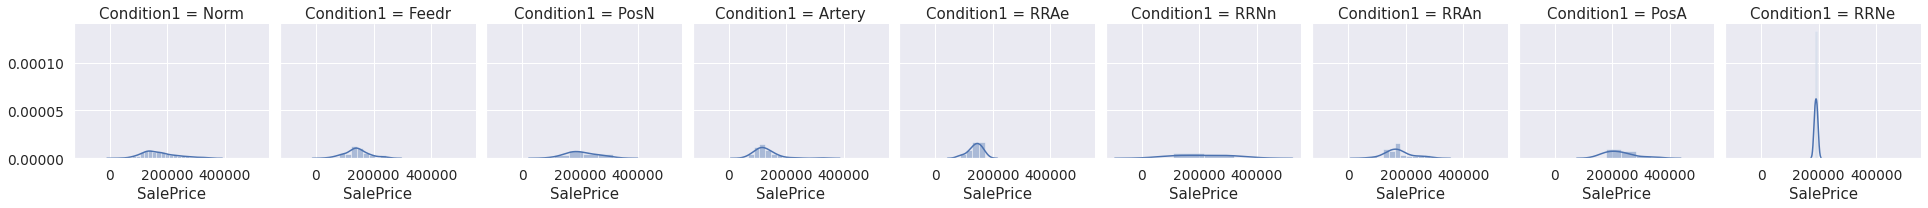

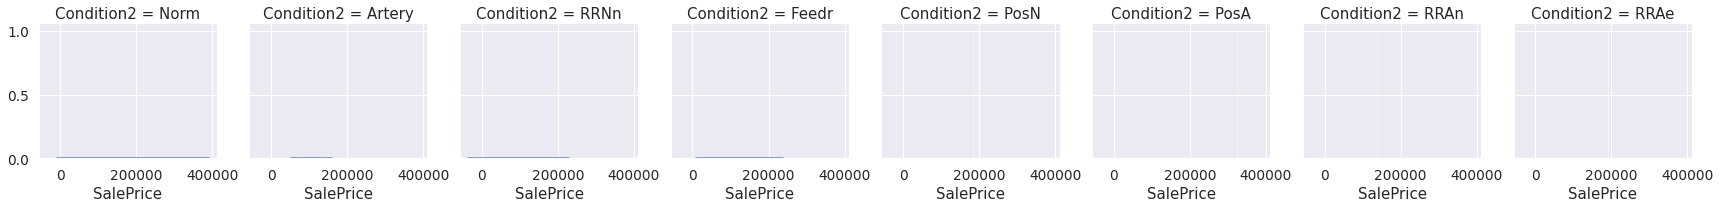

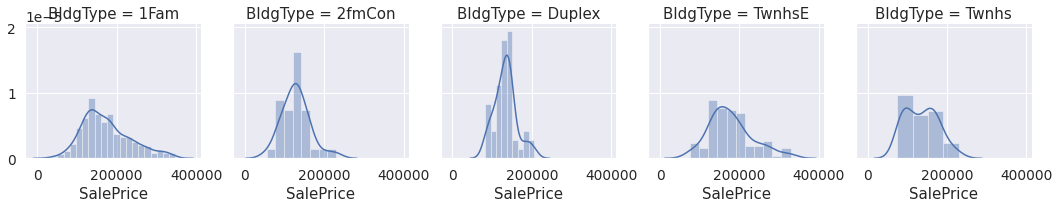

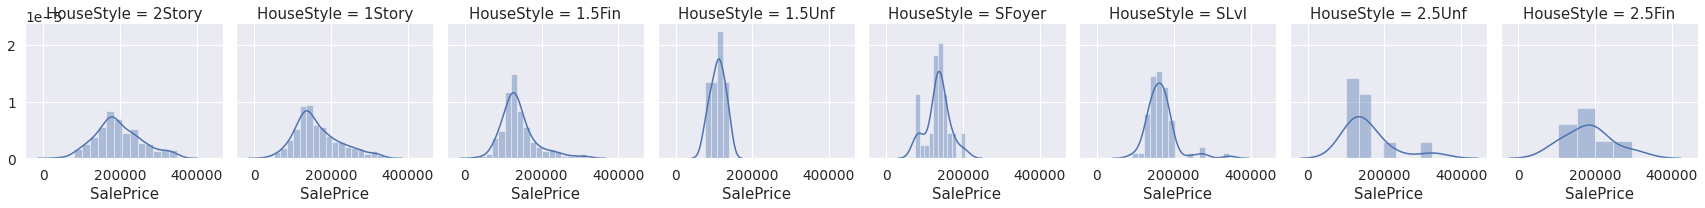

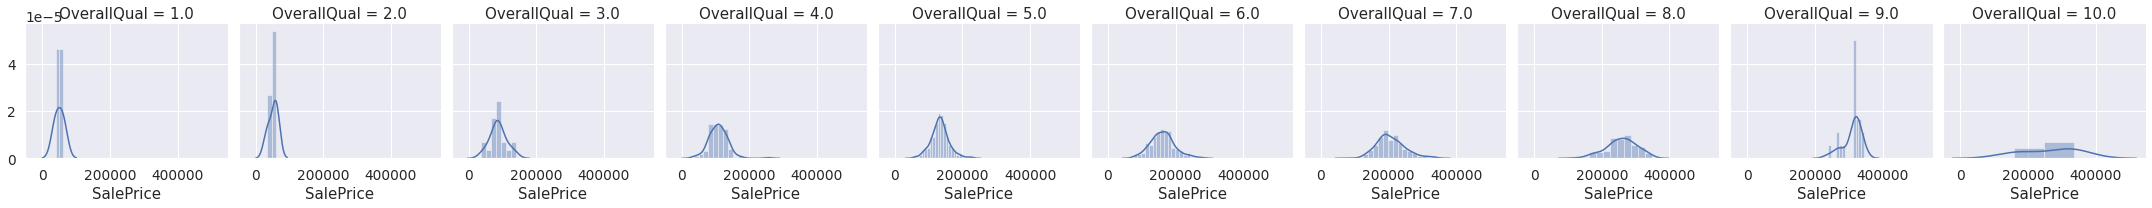

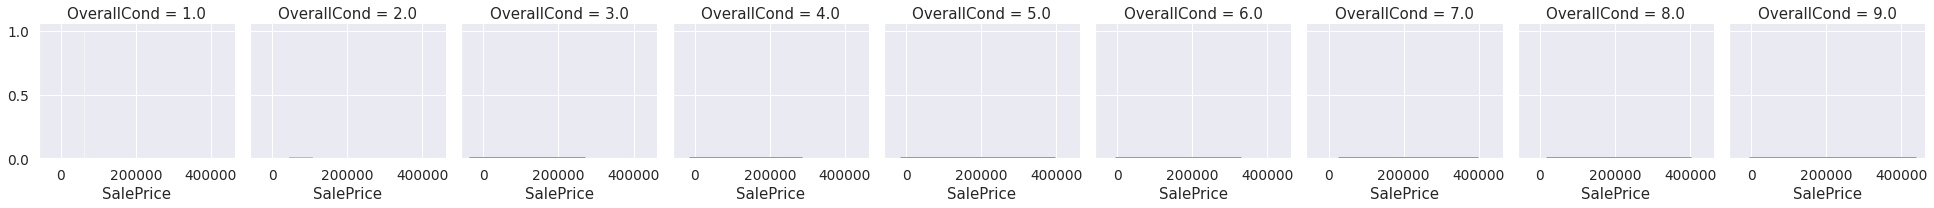

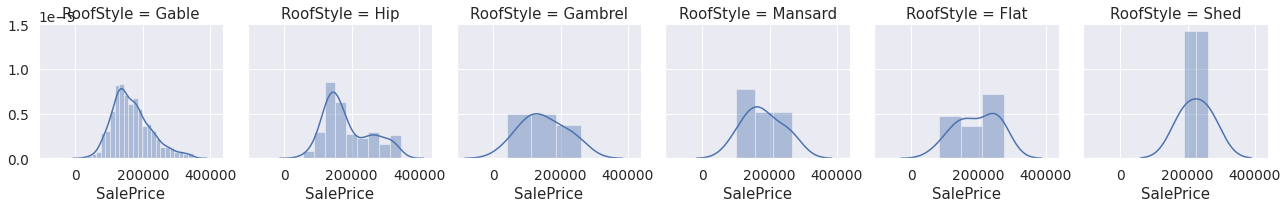

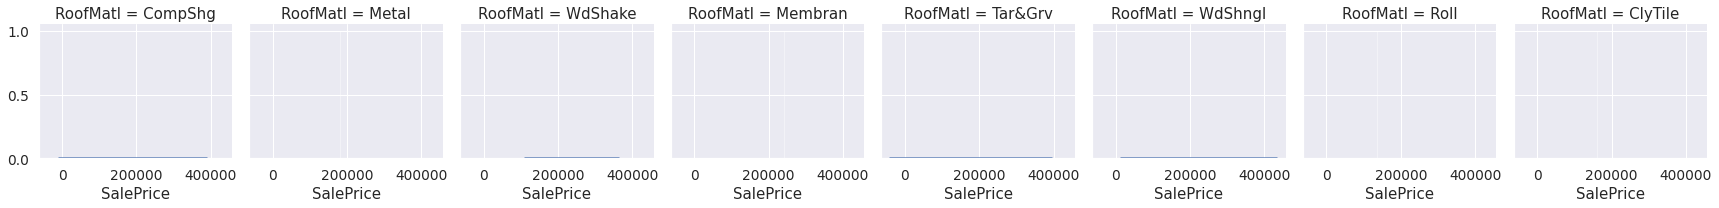

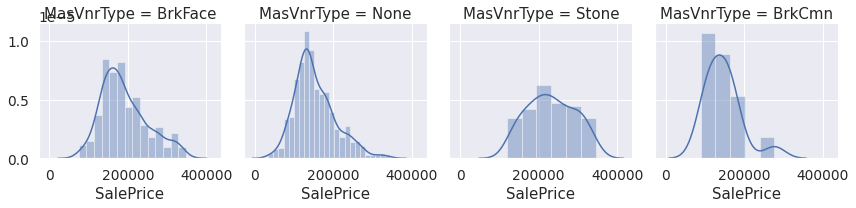

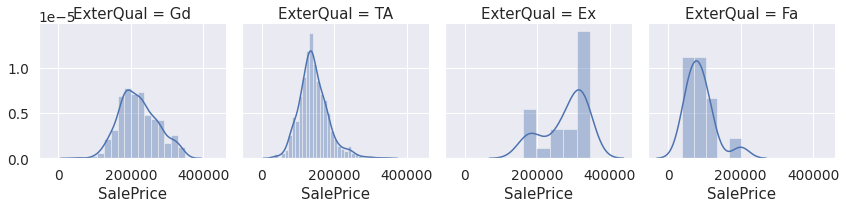

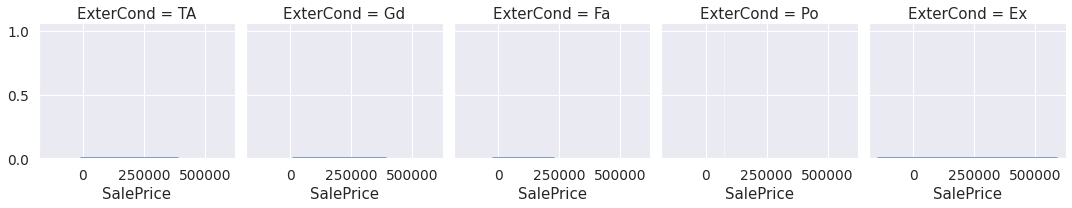

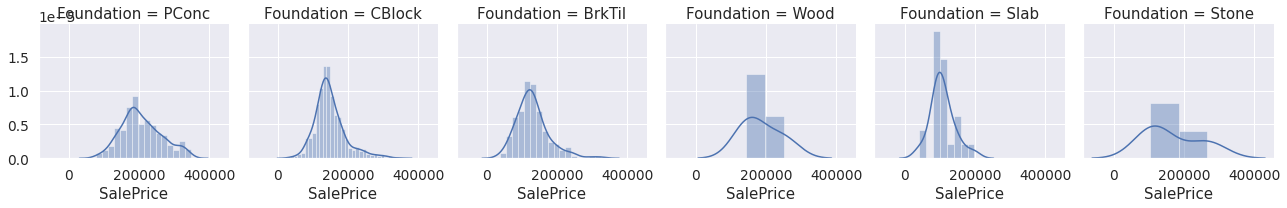

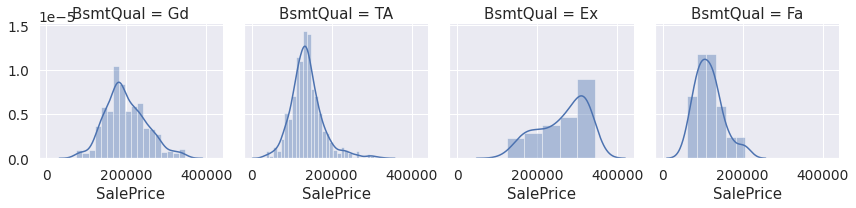

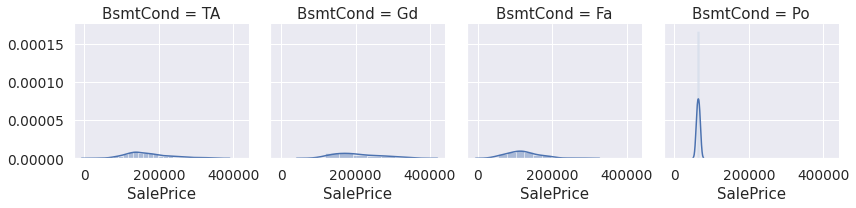

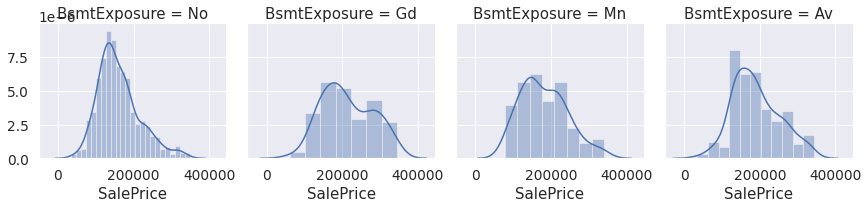

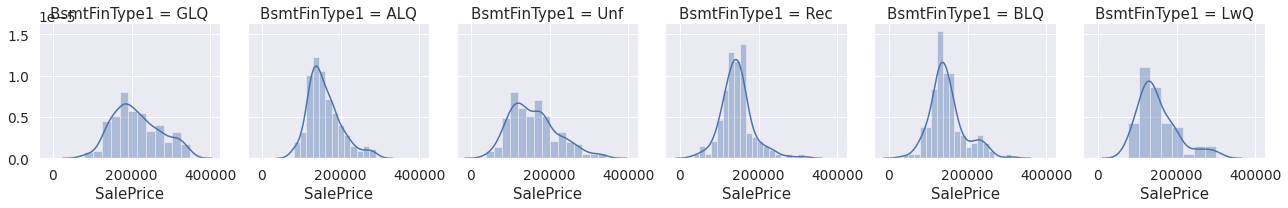

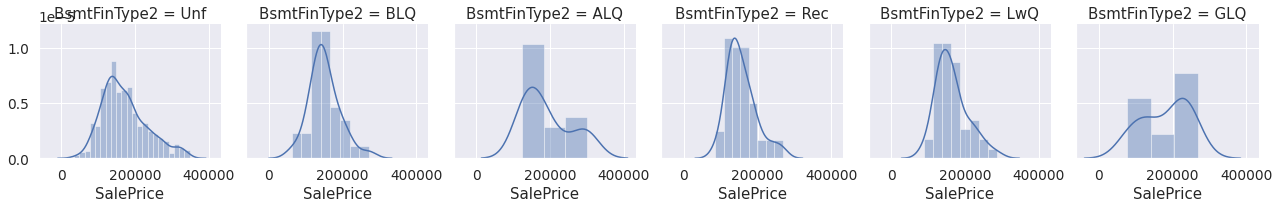

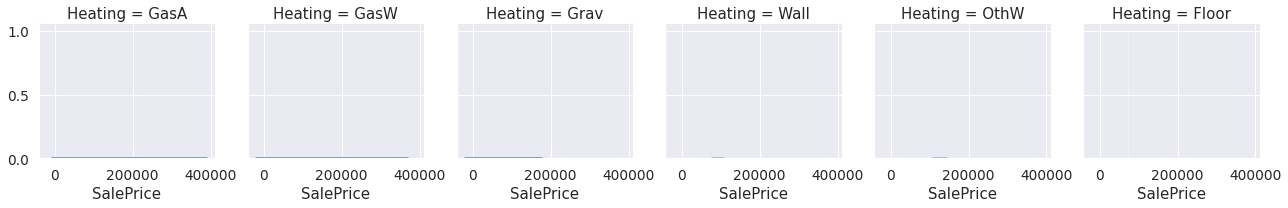

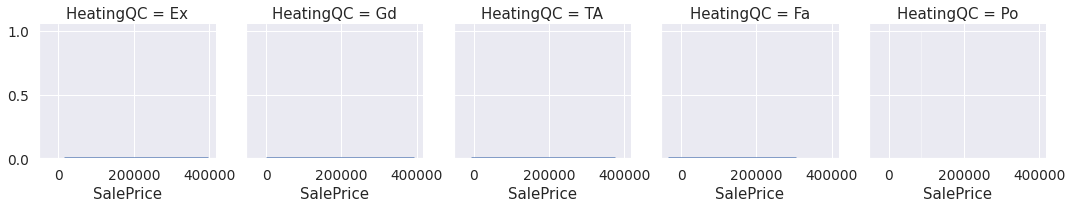

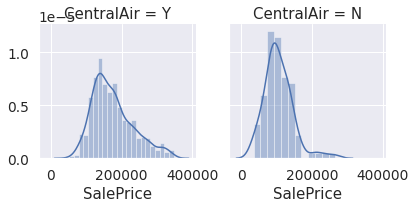

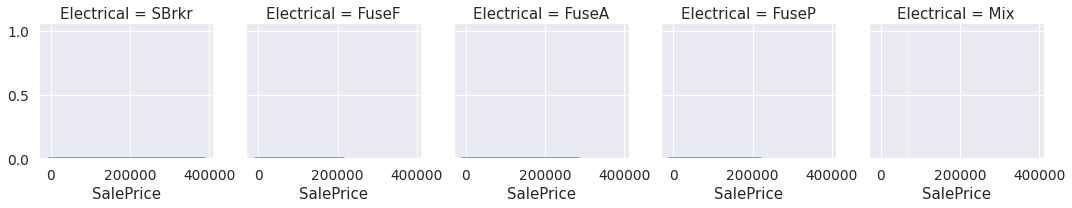

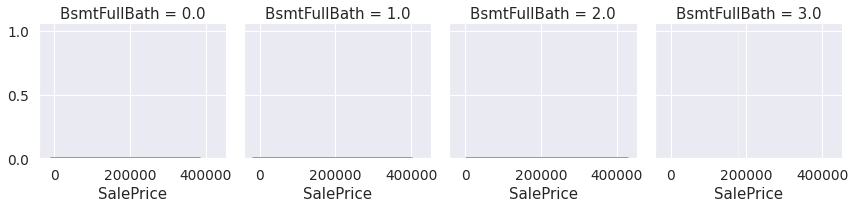

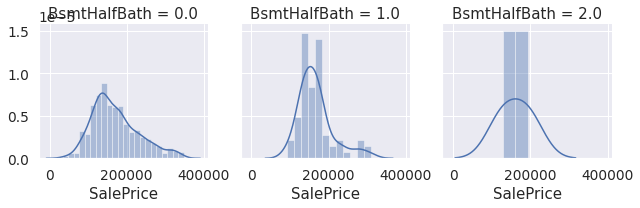

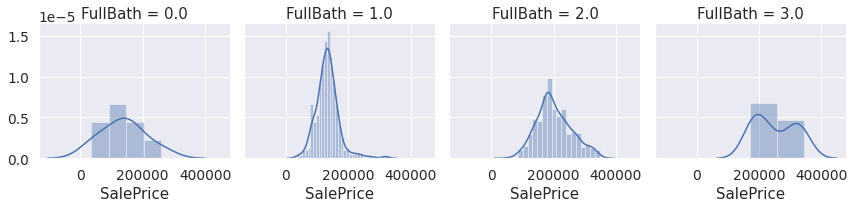

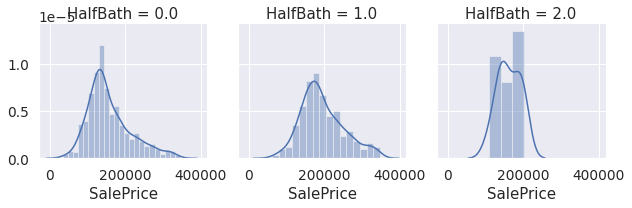

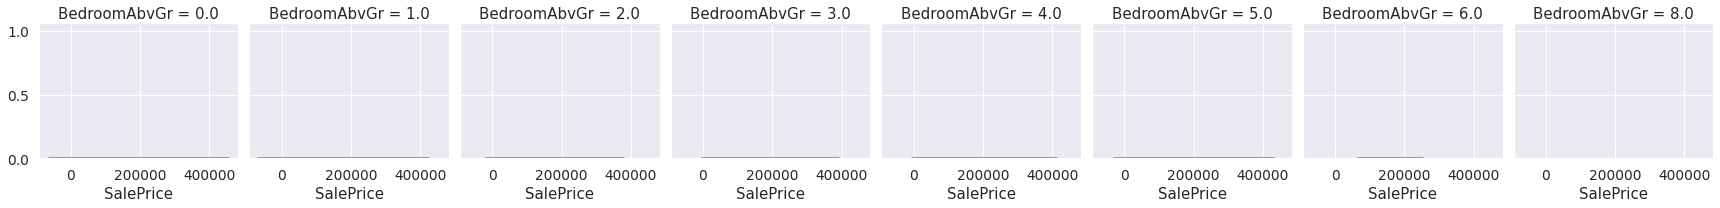

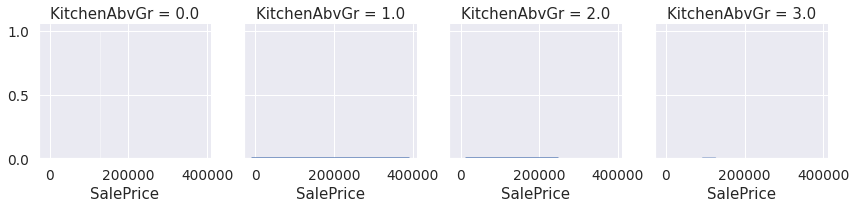

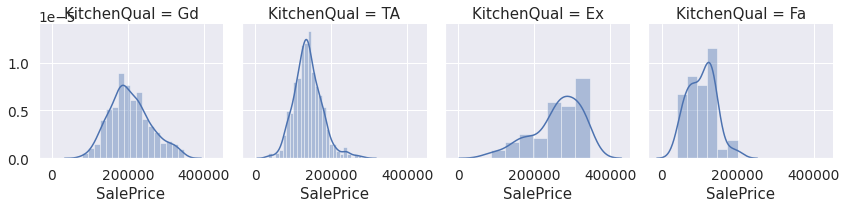

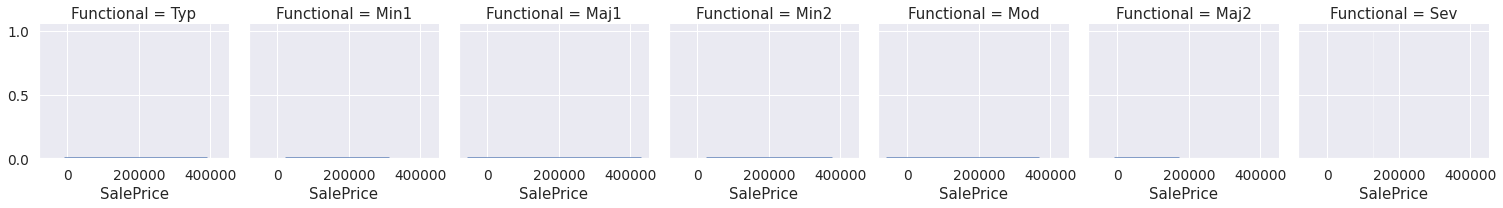

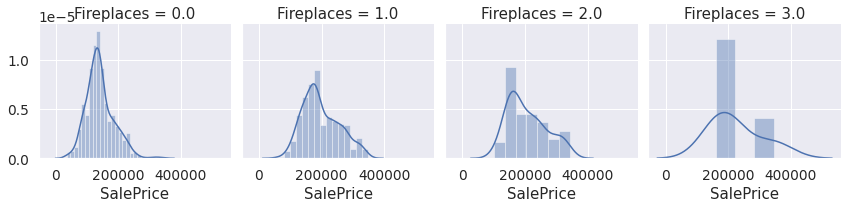

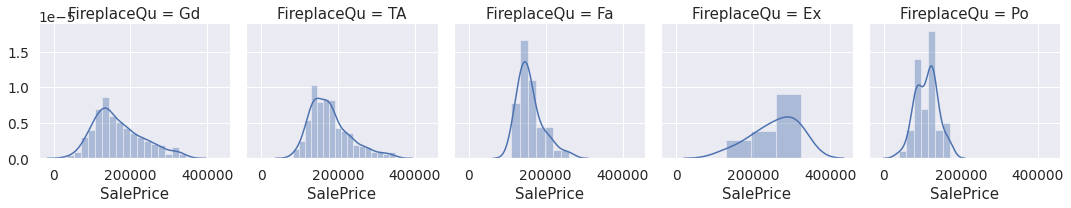

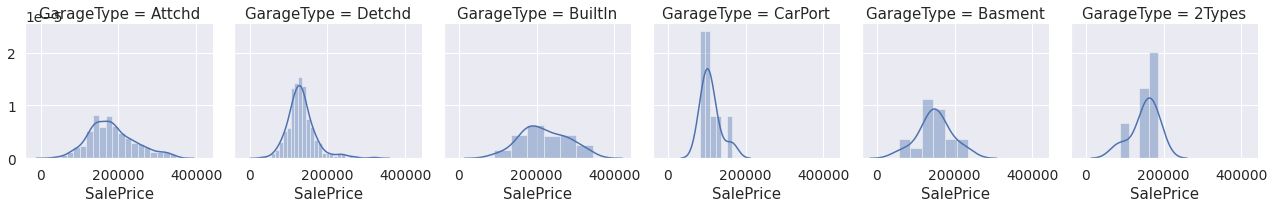

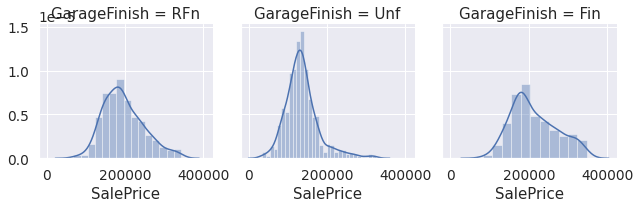

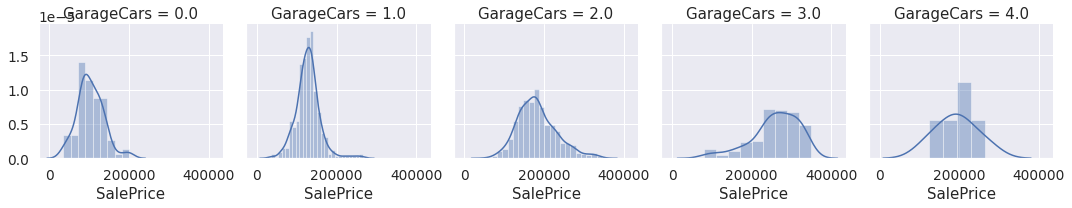

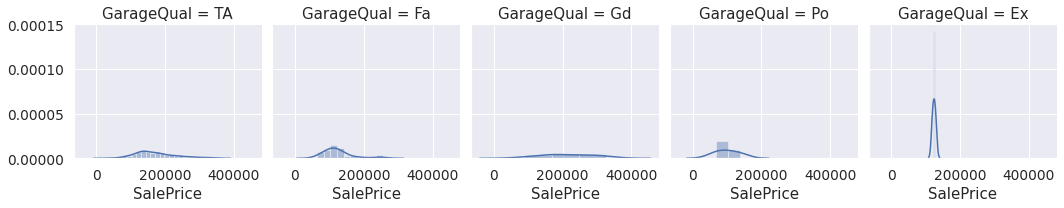

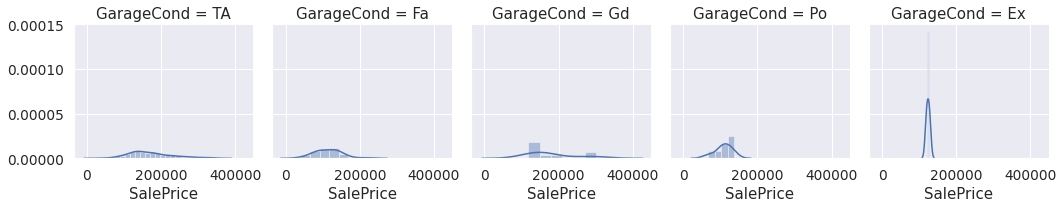

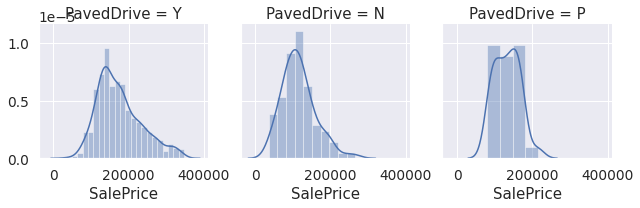

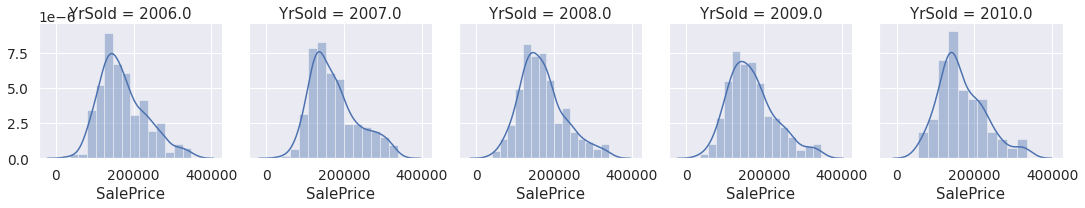

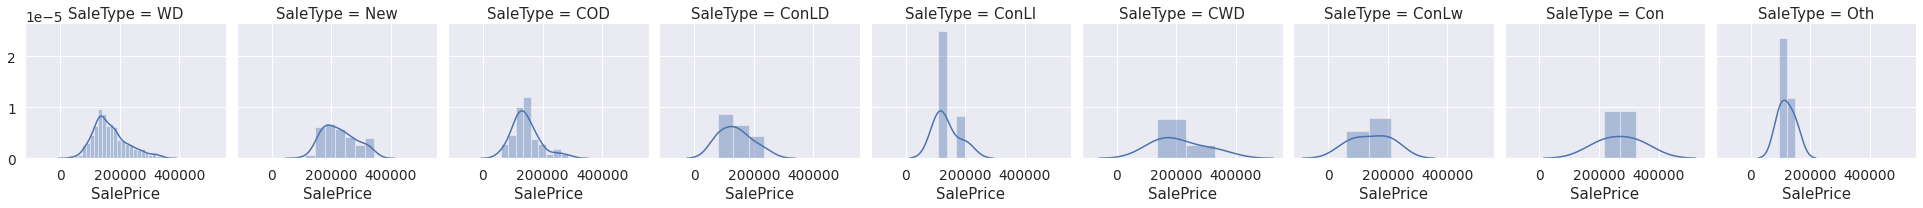

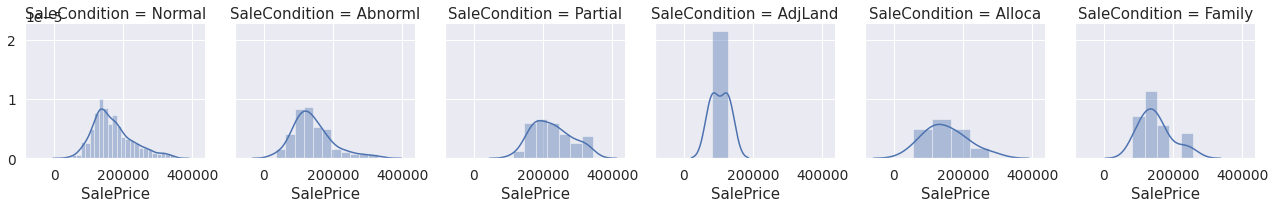

In [95]:
for i in cat_data:
  g = sns.FacetGrid(tx, col=i)
  g.map(sns.distplot, "SalePrice")

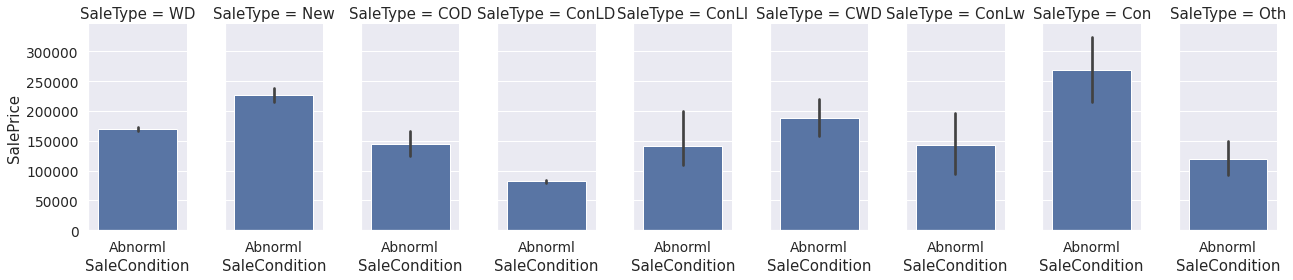

In [96]:
g = sns.FacetGrid(tx, col="SaleType", height=4, aspect=.5)
g.map(sns.barplot, "SaleCondition", "SalePrice")

In [97]:
tx.head()

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
0        60.0       RL         65.0  ...        WD        Normal    208500
1        20.0       RL         80.0  ...        WD        Normal    181500
2        60.0       RL         68.0  ...        WD        Normal    223500
3        70.0       RL         60.0  ...        WD       Abnorml    140000
4        60.0       RL         84.0  ...        WD        Normal    250000

[5 rows x 76 columns]

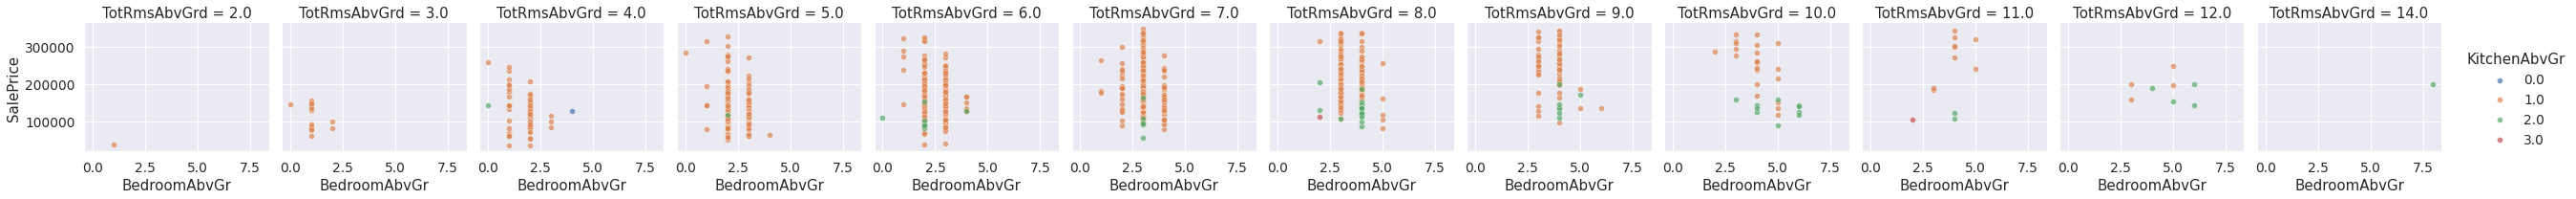

In [98]:
g = sns.FacetGrid(tx, col="TotRmsAbvGrd", hue="KitchenAbvGr" )
g.map(sns.scatterplot, "BedroomAbvGr", "SalePrice", alpha=.7  )
g.add_legend()

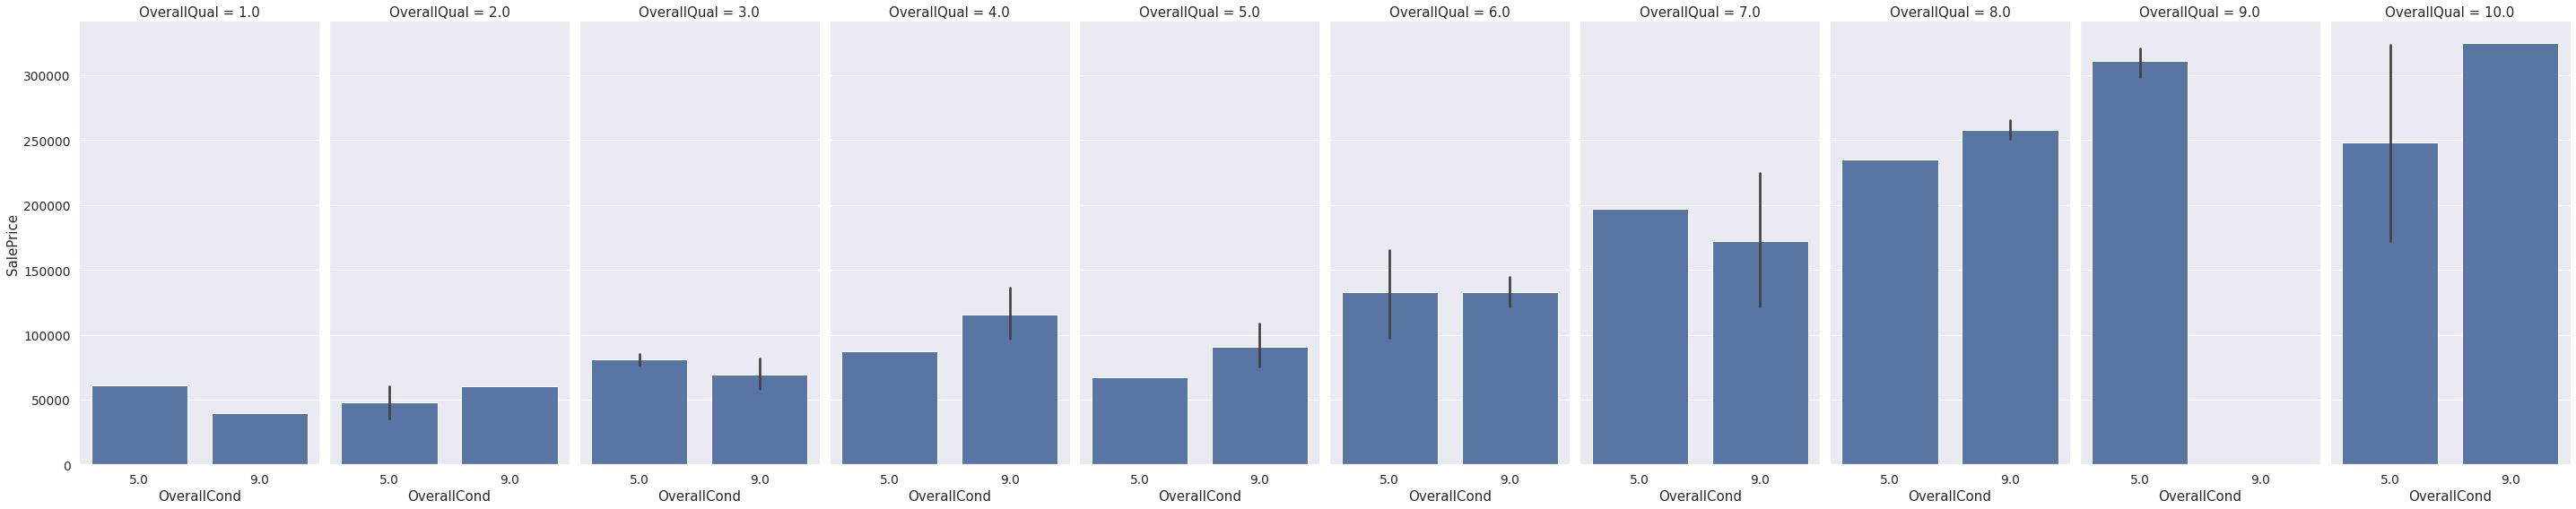

In [99]:
g = sns.FacetGrid(tx, col="OverallQual", height=8, aspect=.5)
g.map(sns.barplot, "OverallCond", "SalePrice")

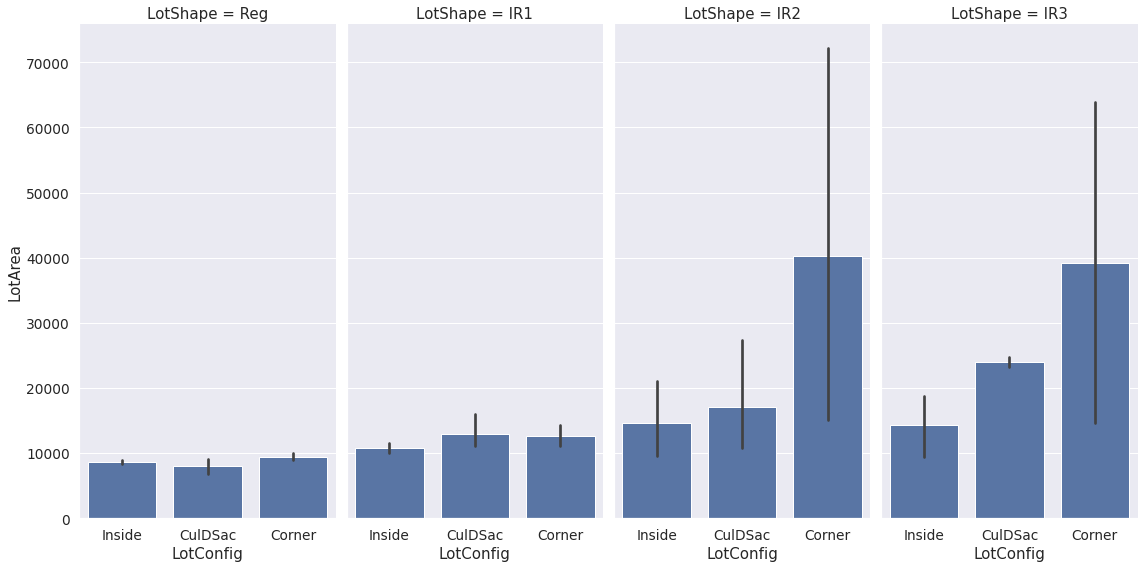

In [100]:
g = sns.FacetGrid(tx, col="LotShape", height=8, aspect=.5)
g.map(sns.barplot, "LotConfig", "LotArea")

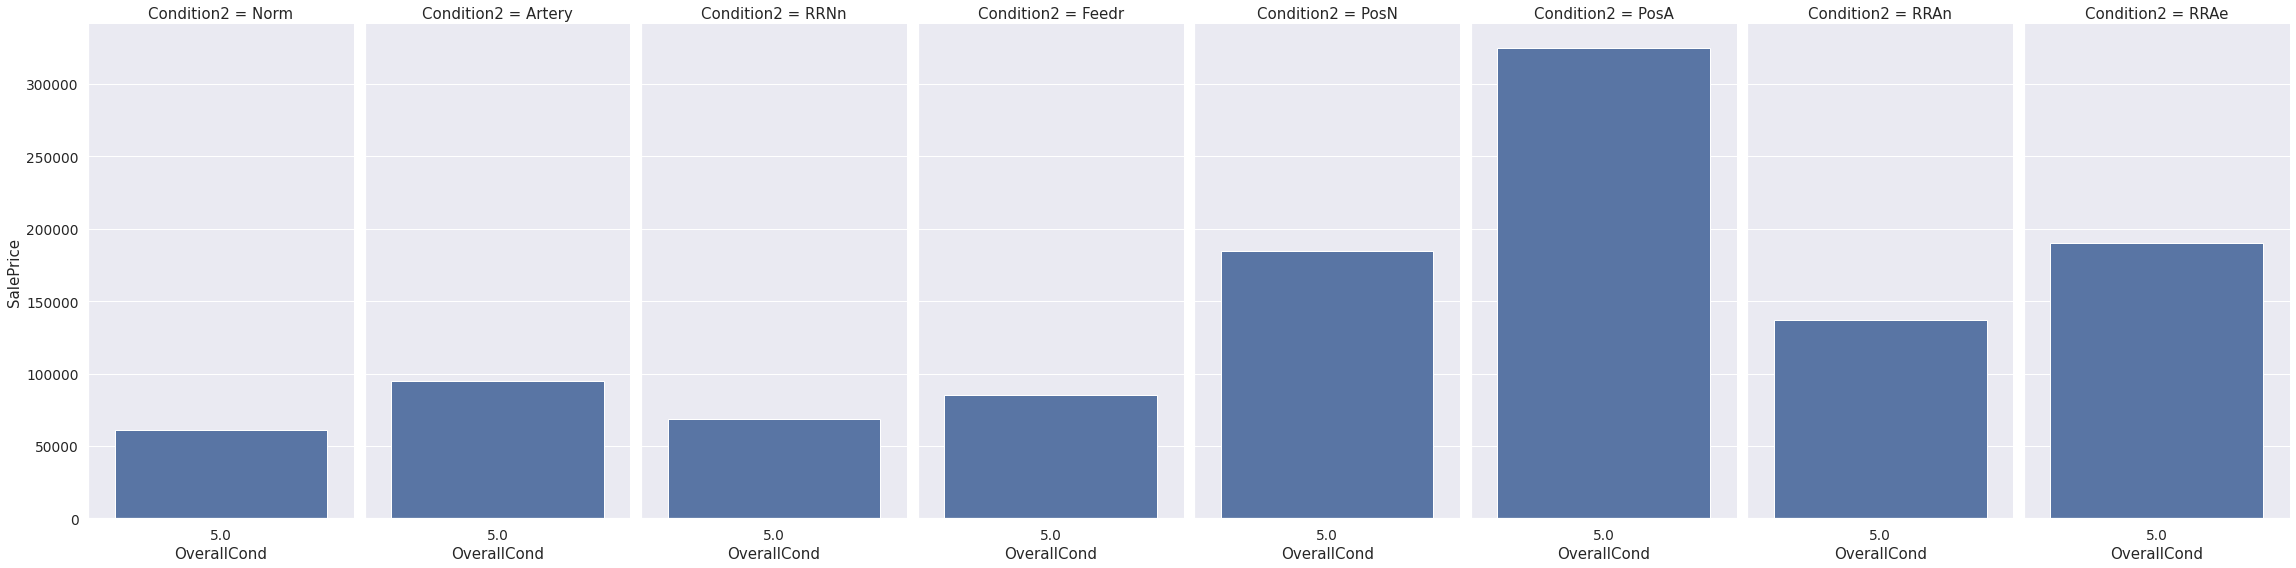

In [101]:
g = sns.FacetGrid(tx, col="Condition2", height=8, aspect=.5)
g.map(sns.barplot, "OverallCond", "SalePrice")

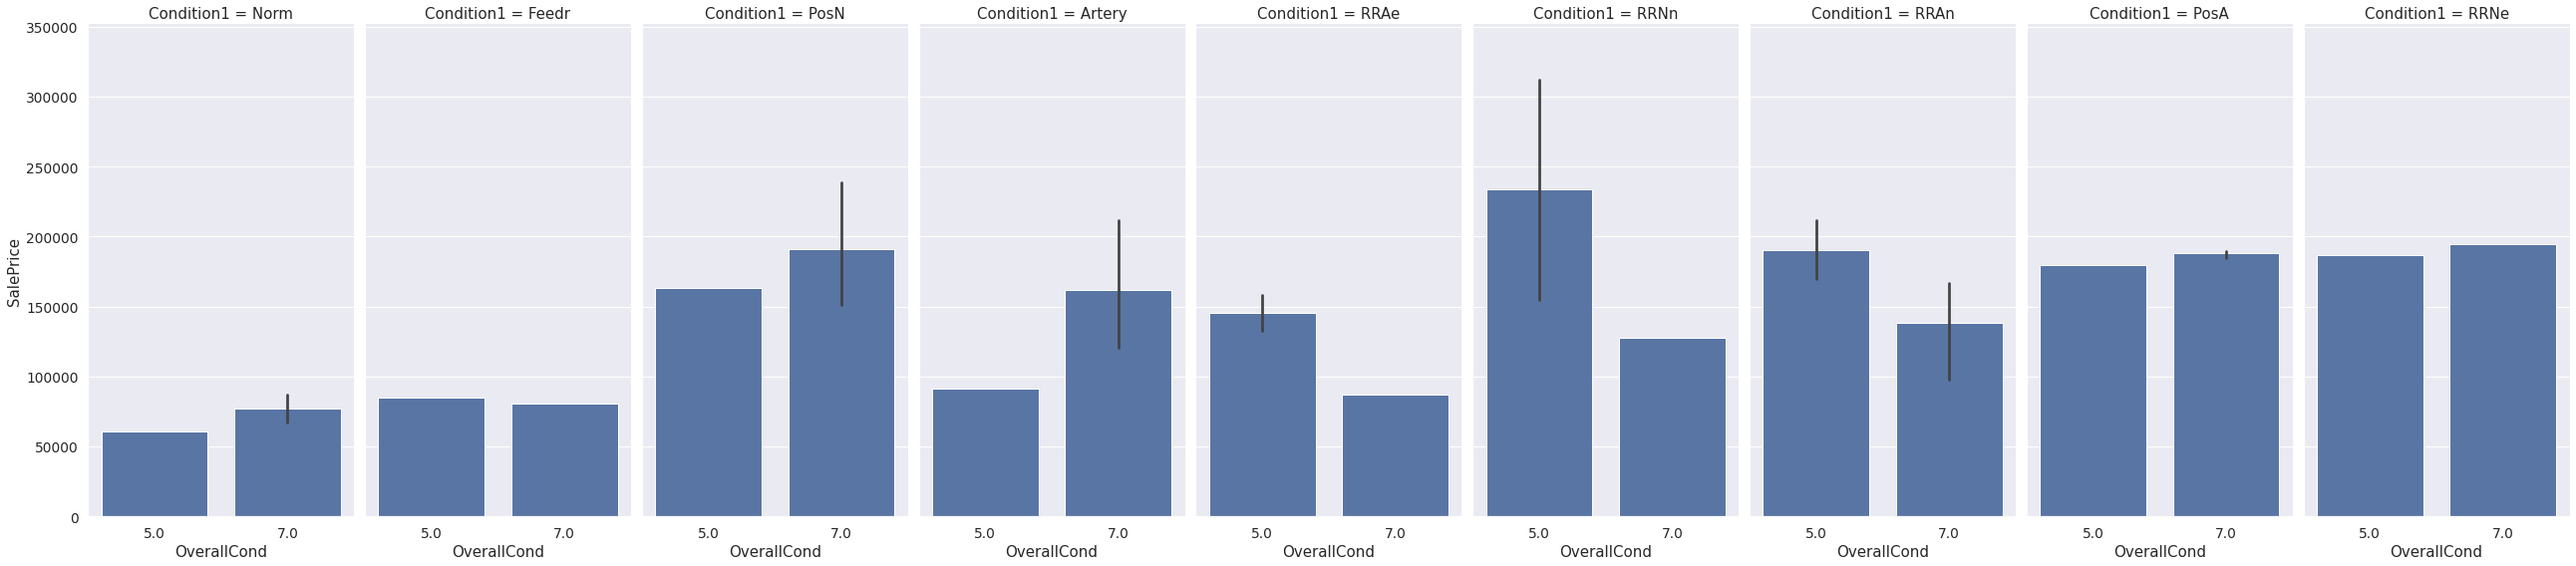

In [102]:
g = sns.FacetGrid(tx, col="Condition1", height=8, aspect=.5)
g.map(sns.barplot, "OverallCond", "SalePrice")

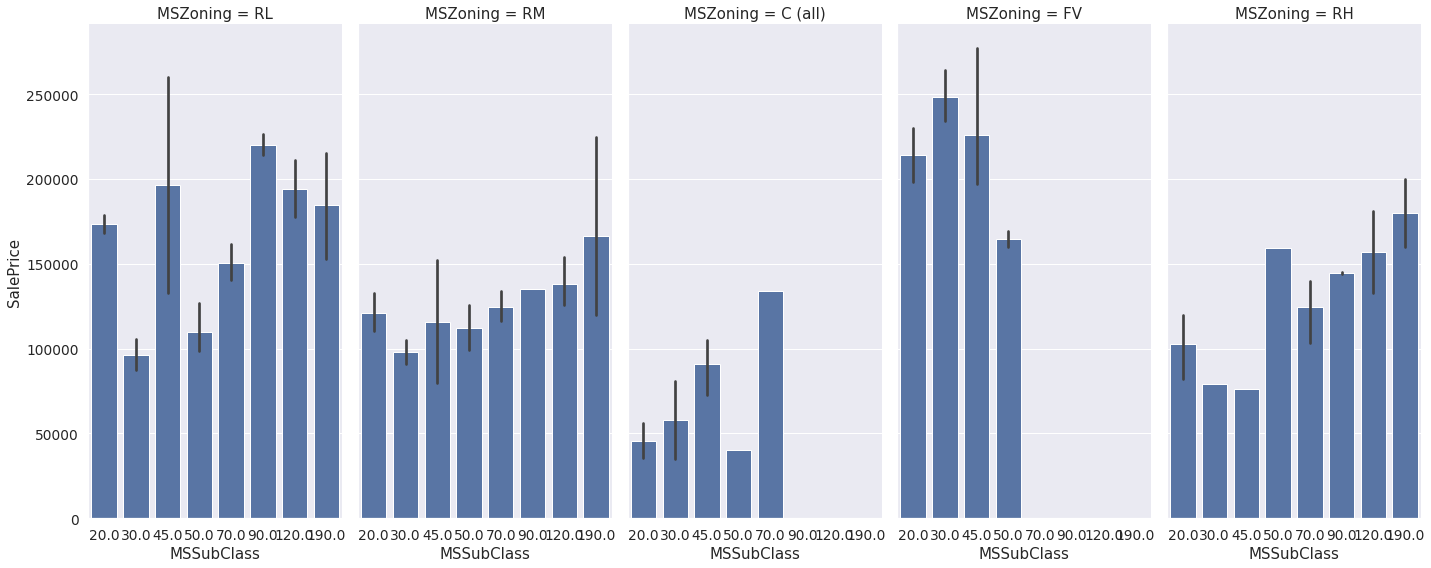

In [103]:
g = sns.FacetGrid(tx, col="MSZoning", height=8, aspect=.5)
g.map(sns.barplot, "MSSubClass", "SalePrice")

<h1> Numerical Data Visualization<h1>

In [104]:
data.select_dtypes(exclude=object)

MSSubClass  LotFrontage  LotArea  ...  MiscVal  MoSold  YrSold
0           60.0         65.0   8450.0  ...      0.0     2.0  2008.0
1           20.0         80.0   9600.0  ...      0.0     5.0  2007.0
2           60.0         68.0  11250.0  ...      0.0     9.0  2008.0
3           70.0         60.0   9550.0  ...      0.0     2.0  2006.0
4           60.0         84.0  14260.0  ...      0.0    12.0  2008.0
...          ...          ...      ...  ...      ...     ...     ...
1454       160.0         21.0   1936.0  ...      0.0     6.0  2006.0
1455       160.0         21.0   1894.0  ...      0.0     4.0  2006.0
1456        20.0        160.0  20000.0  ...      0.0     9.0  2006.0
1457        85.0         62.0  10441.0  ...    700.0     7.0  2006.0
1458        60.0         74.0   9627.0  ...      0.0    11.0  2006.0

[2863 rows x 36 columns]

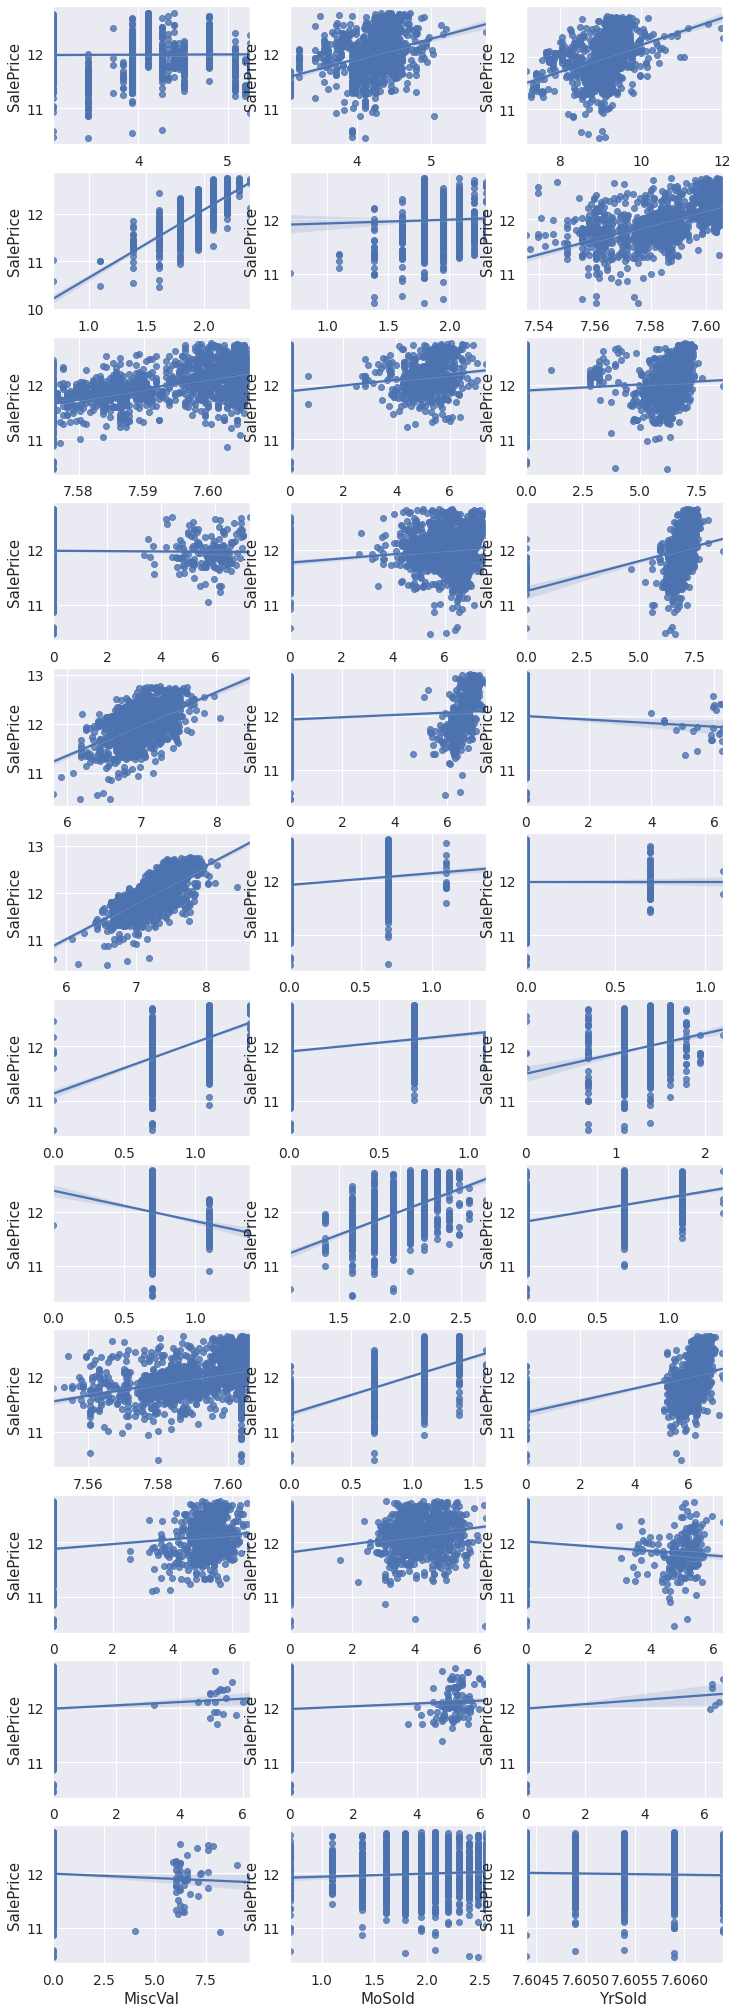

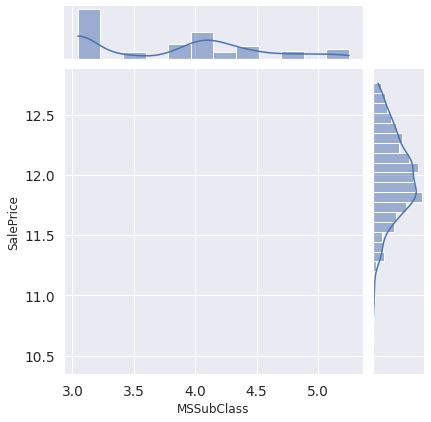

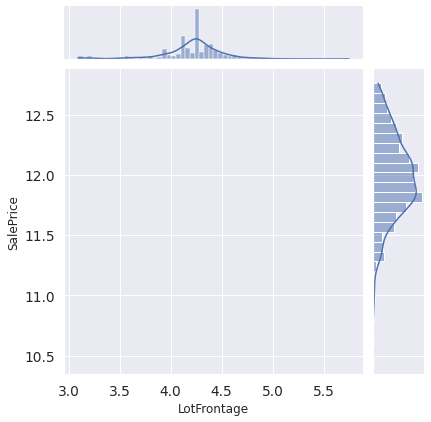

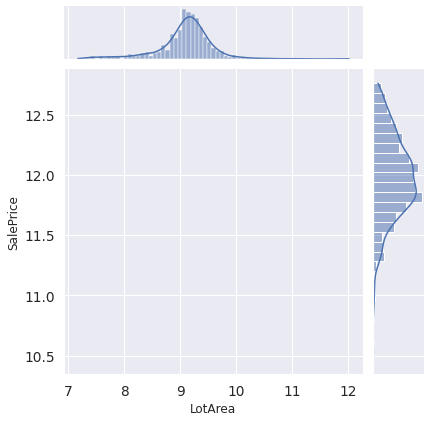

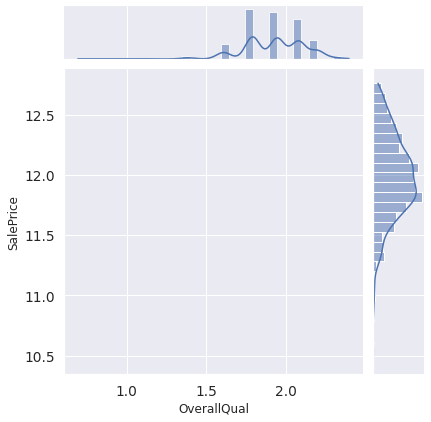

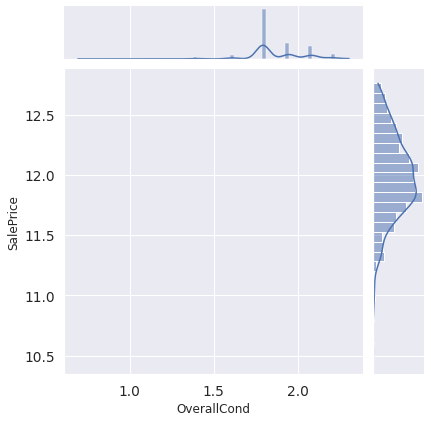

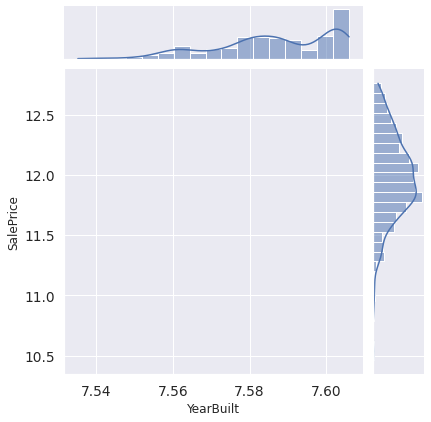

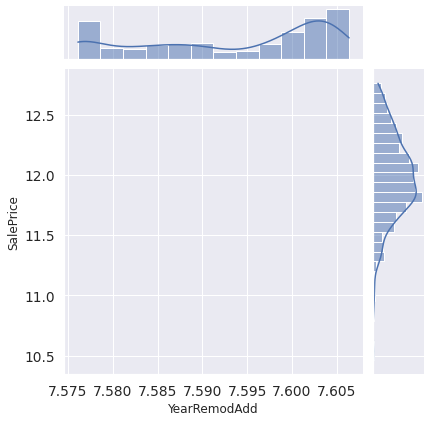

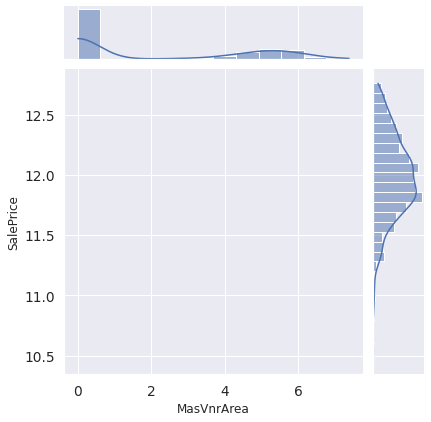

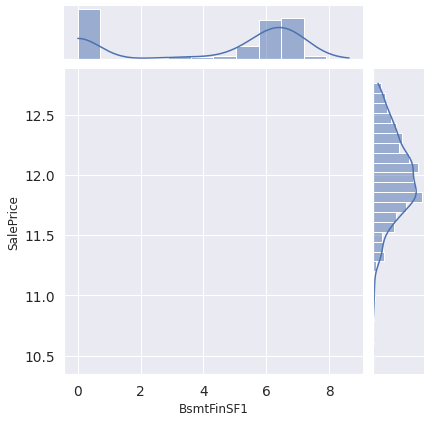

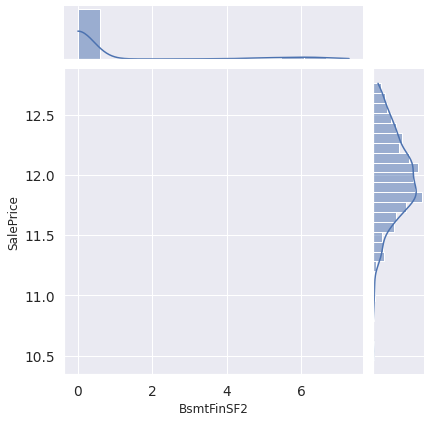

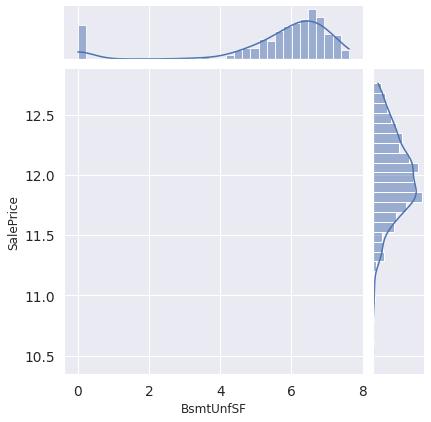

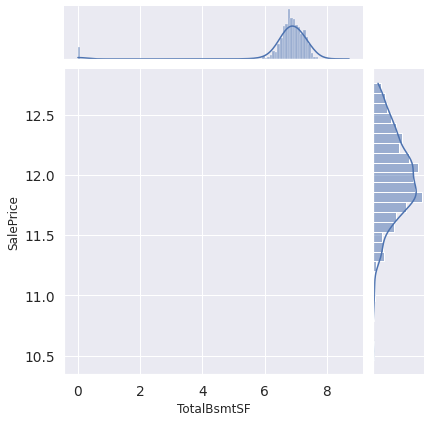

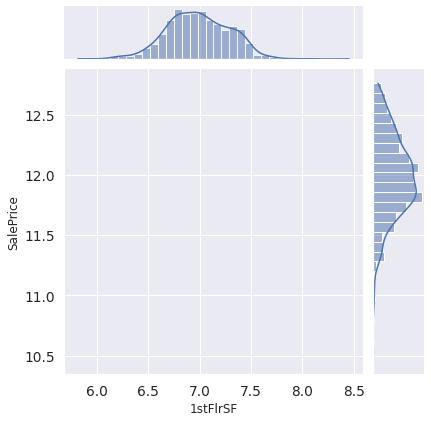

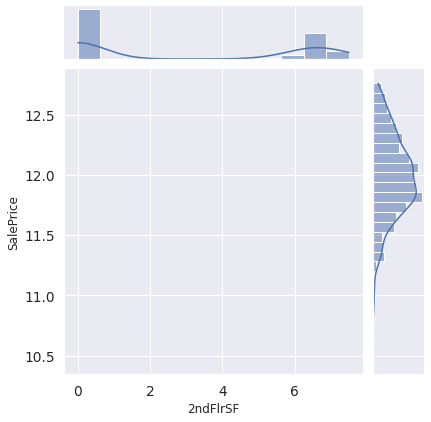

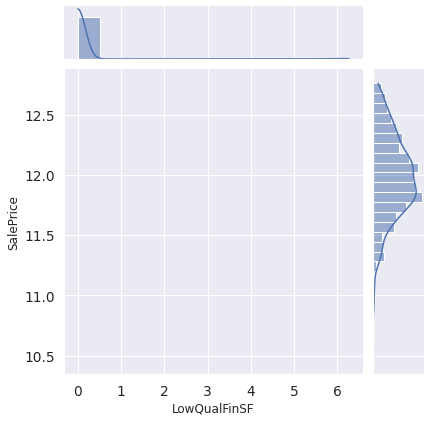

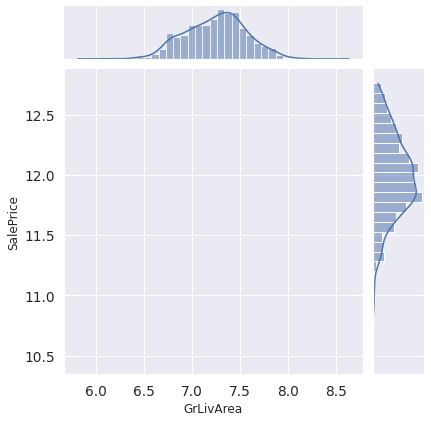

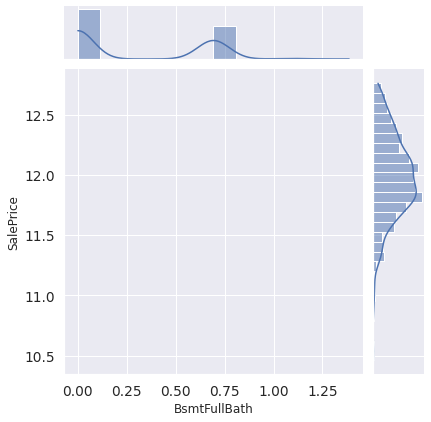

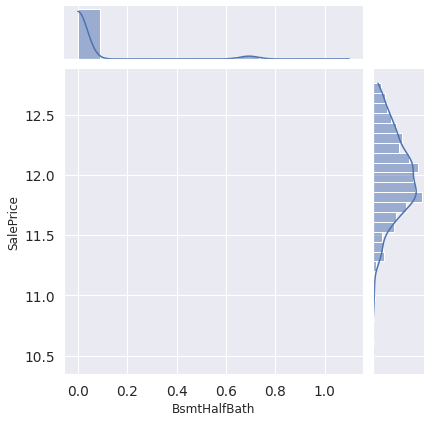

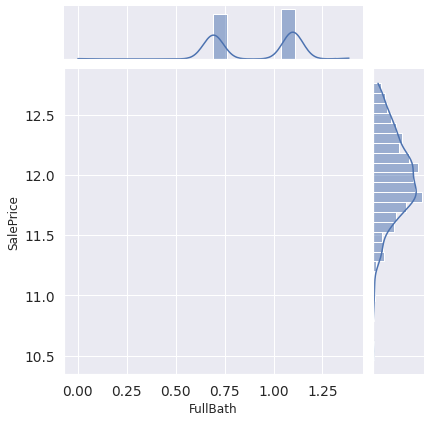

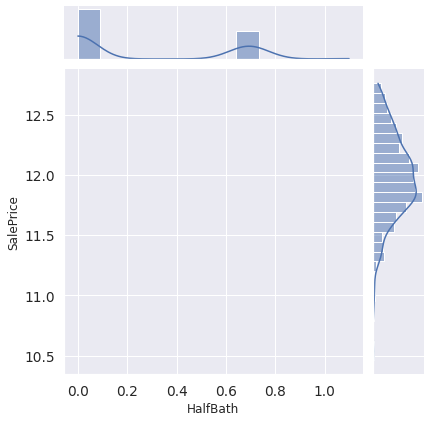

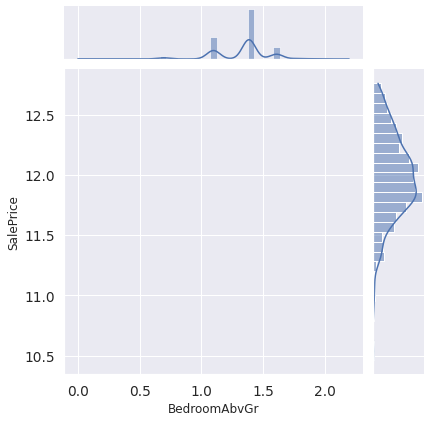

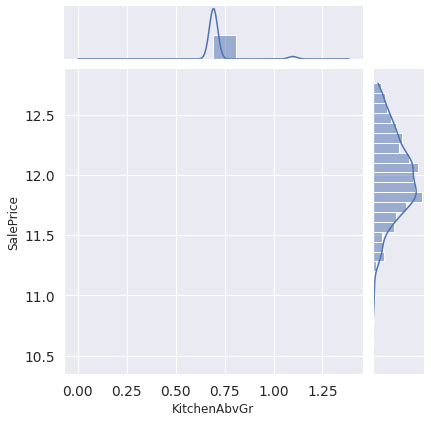

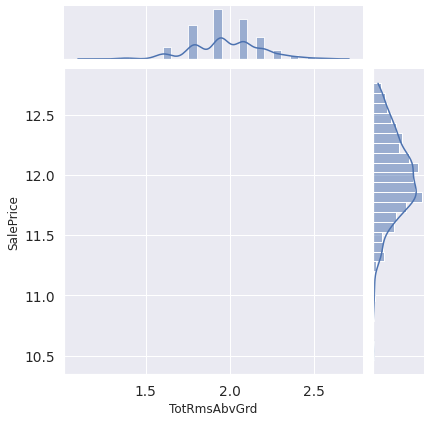

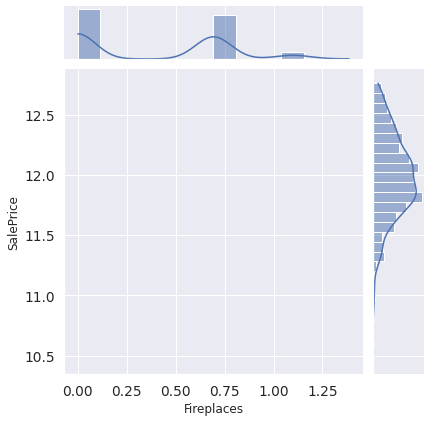

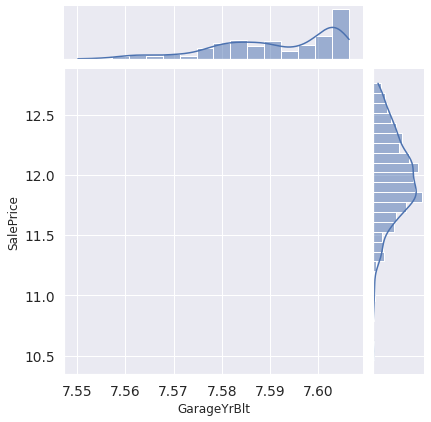

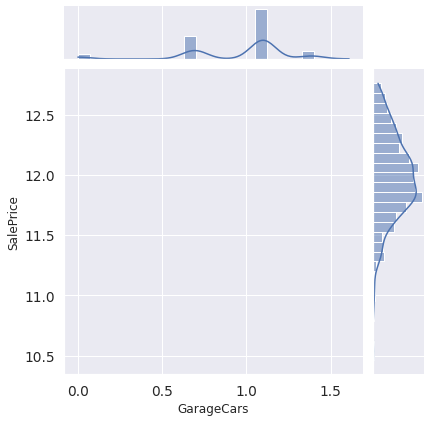

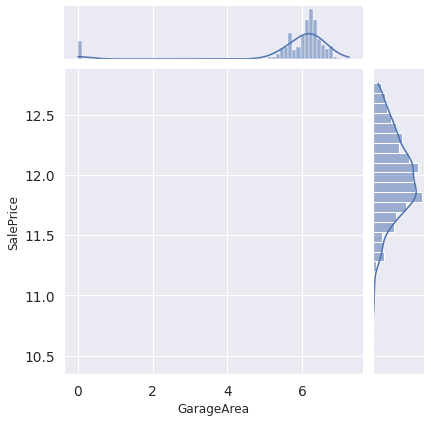

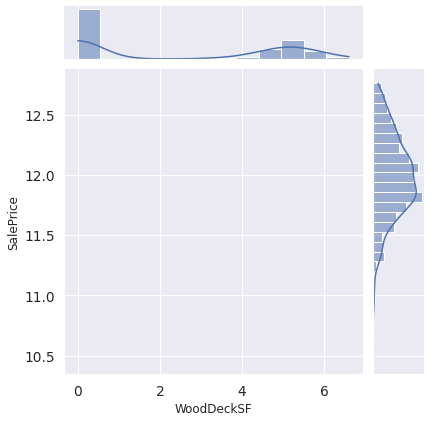

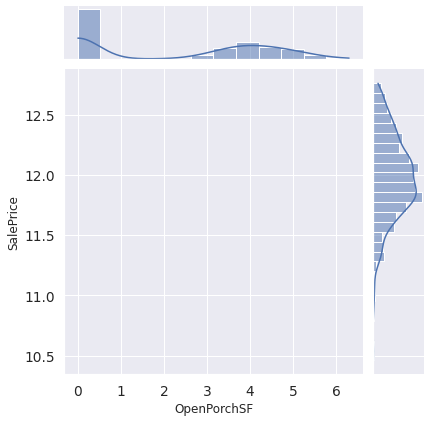

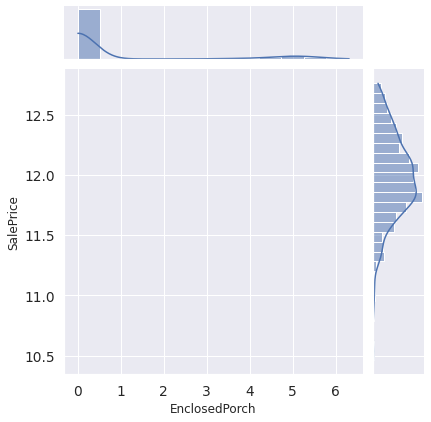

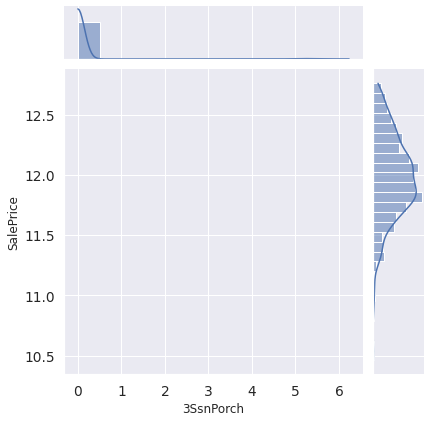

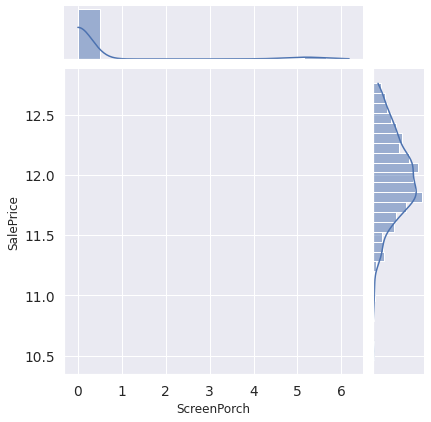

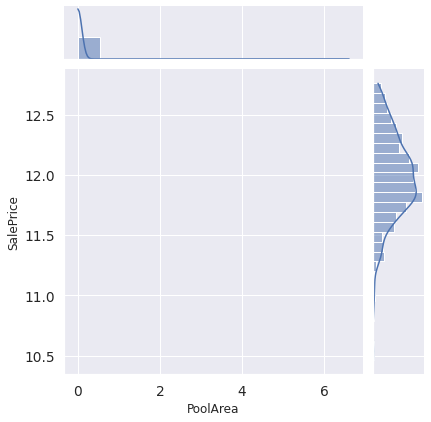

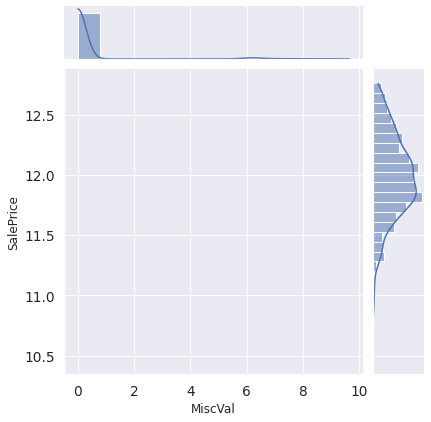

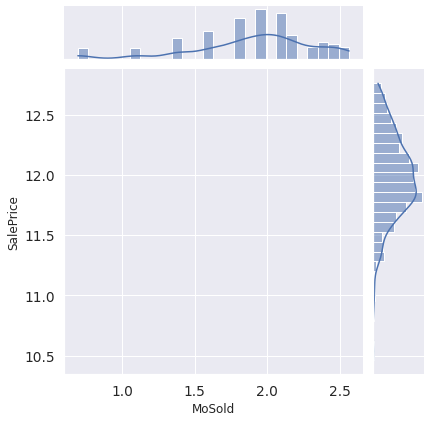

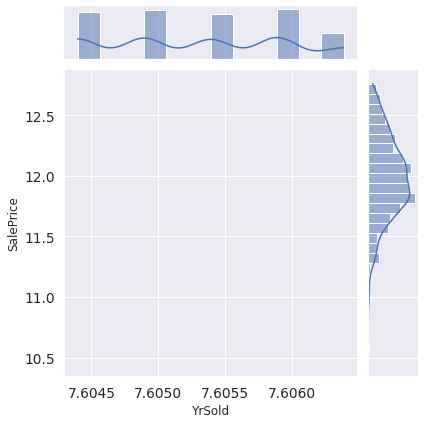

In [105]:
int_col = tx.select_dtypes(exclude=object).columns
#Univariate Analysis
nr_rows = 12
nr_cols = 3
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
i = 0
for r in range(0,nr_rows):
    for c in range(0, nr_cols):
      if i< len(int_col):
        sns.jointplot(x = np.log1p(tx[int_col[i]]), y = np.log1p(y), data = tx, kind = 'reg', ax = axs[r][c])
        plt.ylabel('SalePrice', fontsize=12)
        plt.xlabel(int_col[i], fontsize=12)
        i+=1
      else:
        break
plt.tight_layout()    
plt.show()


<h1>Encoding Categorical Data (Way - 1)</h1>

In [106]:
data_copy = data.copy()

In [107]:
# Encode Ordinal Data
qual_listt = ['HeatingQC','OverallQual','ExterQual','BsmtQual','KitchenQual','FireplaceQu','GarageQual']
cond_listt = ['OverallCond','ExterCond','BsmtCond','GarageCond']
dic = {'NA':.5,'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 3.5, 'Ex': 5}
for i in (qual_listt+cond_listt):
  if data_copy[i].dtype == object:
    data_copy[i] = data_copy[i].map(dic)

In [108]:
tx.groupby(['Electrical'])['SalePrice'].mean().sort_values(ascending = True)

Electrical
Mix       67000.000000
FuseP     97333.333333
FuseF    107675.444444
FuseA    122196.893617
SBrkr    176020.827991
Name: SalePrice, dtype: float64

In [109]:

house_style = {'1.5Unf':1,'SFoyer':2, '1.5Fin': 3, '2.5Unf': 4, 'SLvl': 5, '1Story': 6, '2Story': 7, '2.5Fin': 8}
utilities = {'NoSeWa':1,'AllPub':2}
roof_matl = {'Roll':1,'ClyTile':2, 'CompShg': 3, 'Metal': 4, 'Tar&Grv': 5, 'WdShake': 6, 'Membran': 7, 'WdShngl': 8}
heating = {'Floor':1,'Grav':2, 'Wall': 3, 'OthW': 4, 'GasW': 5, 'GasA': 6}
electrical = {'Mix':1,'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5}

data_copy['Utilities'] = data_copy['Utilities'].map(utilities)
data_copy['HouseStyle'] = data_copy['HouseStyle'].map(house_style)
data_copy['RoofMatl'] = data_copy['RoofMatl'].map(roof_matl)
data_copy['Heating'] = data_copy['Heating'].map(heating)
data_copy['Electrical'] = data_copy['Electrical'].map(electrical)

In [110]:
data_copy.head()

MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0        60.0       RL         65.0  ...  2008.0       WD        Normal
1        20.0       RL         80.0  ...  2007.0       WD        Normal
2        60.0       RL         68.0  ...  2008.0       WD        Normal
3        70.0       RL         60.0  ...  2006.0       WD       Abnorml
4        60.0       RL         84.0  ...  2008.0       WD        Normal

[5 rows x 75 columns]

<h1>Encoding Categorical Data (Way - 2)</h1>

In [111]:
# Count Encoding
data_copy = data.copy()
import operator
def count_encoding(data,i):
  if data[i].dtype == object or i in year_all:
    Mean_encoded_subject = data[i].value_counts().to_dict() 
    sorted_d = dict(sorted(Mean_encoded_subject.items(), key=operator.itemgetter(1)))
    li = list(sorted_d)
    new_dict = {}
    for j in li:
      new_dict[j] = li.index(j)+1
    data[i] =  data[i].map(new_dict) 
  return data[i]
for i in data_copy:
  if data_copy[i].dtype == object or i in year_all:
      data_copy[i] = count_encoding(data_copy,i)

In [112]:
data_copy.head()

MSSubClass  MSZoning  LotFrontage  ...  YrSold  SaleType  SaleCondition
0        60.0         5         65.0  ...       3         9              6
1        20.0         5         80.0  ...       5         9              6
2        60.0         5         68.0  ...       3         9              6
3        70.0         5         60.0  ...       2         9              4
4        60.0         5         84.0  ...       3         9              6

[5 rows x 75 columns]

In [113]:
# Mean Encoding
tx_copy = tx.copy()
ty_copy = ty.copy()
def mean_encoding(data,data1):
  for i in data:
    if data[i].dtypes == object or i in year_all:
      Mean_encoded_subject = data.groupby([i])['SalePrice'].mean().to_dict() 
      sorted_d = dict(sorted(Mean_encoded_subject.items(), key=operator.itemgetter(1)))
      li = list(sorted_d)
      new_dict = {}
      for j in li:
        new_dict[j] = li.index(j)+1
      data[i] =  data[i].map(new_dict) 
      data1[i] =  data1[i].map(new_dict) 
  return data, data1  
tx_copy,ty_copy = mean_encoding(tx_copy,ty_copy)

In [114]:
tx_copy.head()

MSSubClass  MSZoning  LotFrontage  ...  SaleType  SaleCondition  SalePrice
0        60.0         4         65.0  ...         6              5     208500
1        20.0         4         80.0  ...         6              5     181500
2        60.0         4         68.0  ...         6              5     223500
3        70.0         4         60.0  ...         6              2     140000
4        60.0         4         84.0  ...         6              5     250000

[5 rows x 76 columns]

<h1>Encoding Categorical Data (Way - 3)</h1>

In [115]:
data_copy = pd.get_dummies(data, drop_first=True)
data_copy.head()

MSSubClass  LotFrontage  ...  SaleCondition_Normal  SaleCondition_Partial
0        60.0         65.0  ...                     1                      0
1        20.0         80.0  ...                     1                      0
2        60.0         68.0  ...                     1                      0
3        70.0         60.0  ...                     0                      0
4        60.0         84.0  ...                     1                      0

[5 rows x 236 columns]

<h1>New Features Generate</h1>

In [116]:
data_copy = data.copy()
data_copy['AgeOfHouse'] = abs(data_copy['YrSold'] - data_copy['YearBuilt'])
data_copy['TotalExtraArea'] = data_copy['WoodDeckSF'] + data_copy['OpenPorchSF'] + data_copy['EnclosedPorch'] + data_copy['3SsnPorch']+ data_copy['PoolArea']
data_copy['GarageAreaPerCar'] = (data_copy['GarageArea']+1) / (data_copy['GarageCars'] +1)
data_copy['TotalBath'] = data_copy['BsmtFullBath'] + data_copy['BsmtHalfBath'] + data_copy['FullBath'] + data_copy['HalfBath']
data_copy['CompletedFloorSF'] = data_copy['1stFlrSF'] + data_copy['2ndFlrSF']
data_copy['CompletedBstmSf'] = data_copy['TotalBsmtSF']- data_copy['BsmtUnfSF']

data_copy.loc[data_copy['Exterior1st'] == data_copy['Exterior2nd'],'Exterior'] = 1
data_copy.loc[data_copy['Exterior1st'] != data_copy['Exterior2nd'],'Exterior'] = 2

data_copy['CompletedBstmSf'] = data_copy['TotalBsmtSF'] + data_copy['BsmtUnfSF']


data_copy.loc[data_copy['Condition1'] == data_copy['Condition2'],'Condition'] = 1
data_copy.loc[data_copy['Condition1'] != data_copy['Condition2'],'Condition'] = 2


data_copy['RemodAdd'] = data_copy['YearBuilt']
for i in range(len(data_copy)):
  if data_copy['YearBuilt'].iloc[i] == data_copy['YearRemodAdd'].iloc[i]:
    data_copy['RemodAdd'].iloc[i] = 0
  else:
    data_copy['RemodAdd'].iloc[i] = abs(data_copy['YearBuilt'].iloc[i]- data_copy['YearRemodAdd'].iloc[i])

data_copy.head()


MSSubClass MSZoning  LotFrontage  ...  Exterior Condition RemodAdd
0        60.0       RL         65.0  ...       1.0       1.0      0.0
1        20.0       RL         80.0  ...       1.0       2.0      0.0
2        60.0       RL         68.0  ...       1.0       1.0      1.0
3        70.0       RL         60.0  ...       2.0       1.0     55.0
4        60.0       RL         84.0  ...       1.0       1.0      0.0

[5 rows x 84 columns]

In [117]:
int_feature = data.select_dtypes(exclude=object).copy()
int_feature.shape

(2863, 36)

In [118]:
tx = int_feature.iloc[:len(y), :]
#ty = skew_feature.iloc[len(tx):, :]
tx['SalePrice'] = y.copy()

In [119]:
tx.iloc[:,0]

0       60.0
1       20.0
2       60.0
3       70.0
4       60.0
        ... 
1399    60.0
1400    20.0
1401    70.0
1402    20.0
1403    20.0
Name: MSSubClass, Length: 1404, dtype: float64

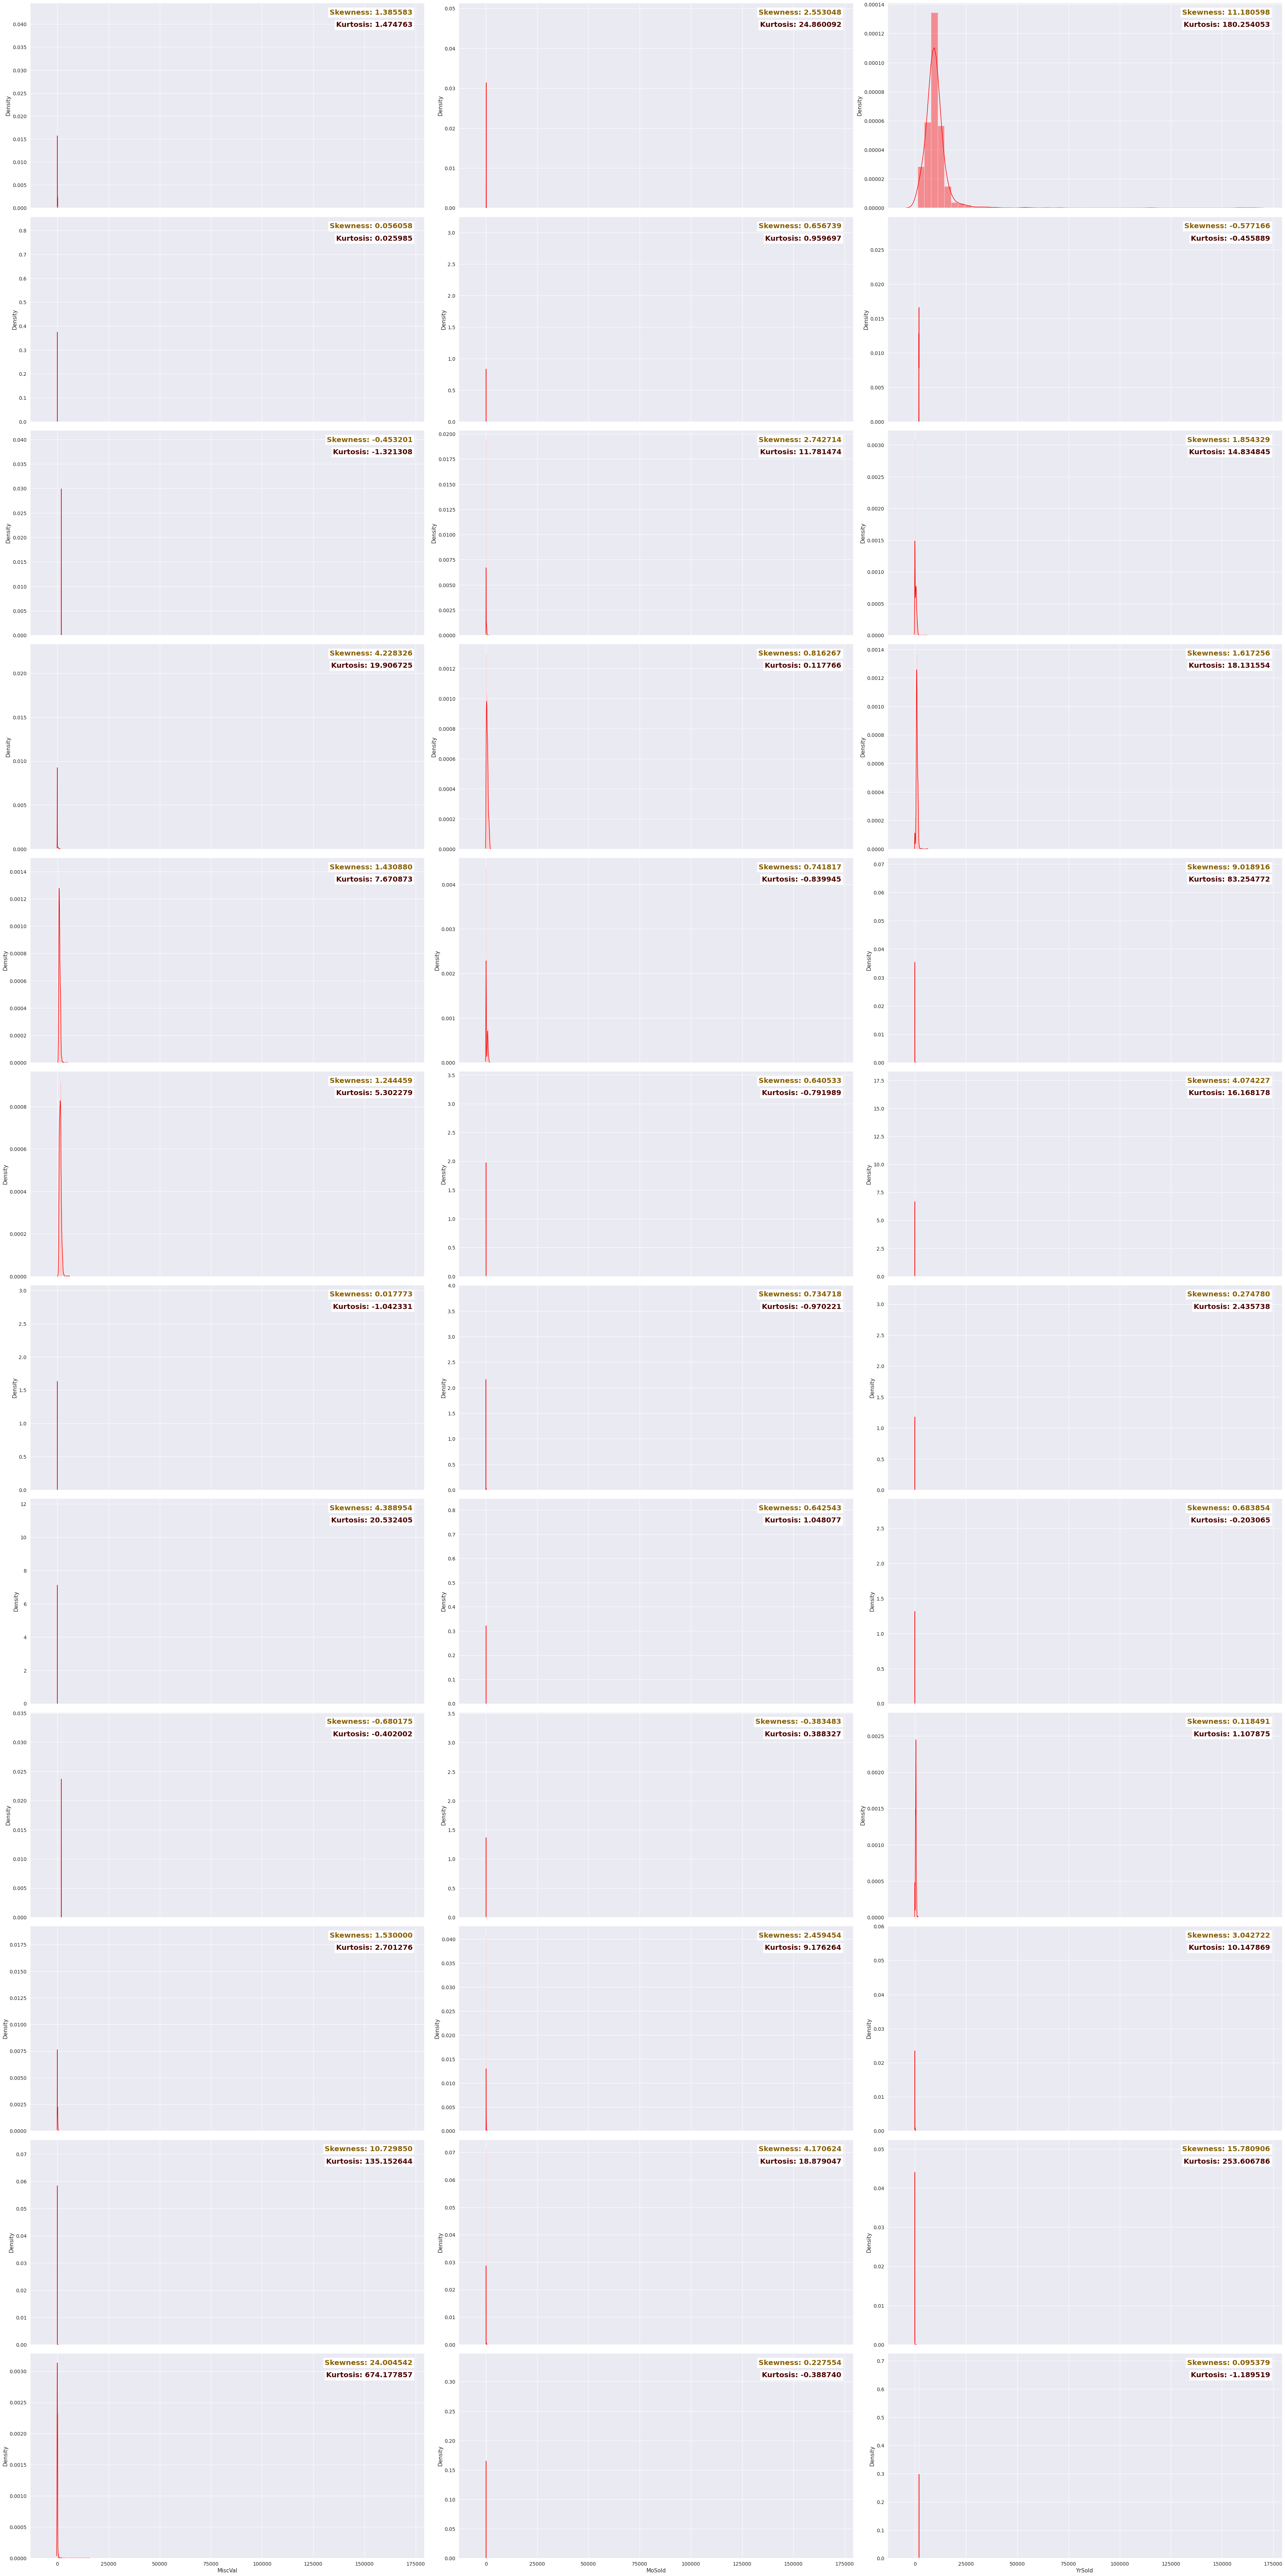

In [120]:
f, axes = plt.subplots(12, 3, figsize=(50, 100), sharex=True)
c = 0
for i in range(12):
  for j in range(3):
    sns.distplot(tx.iloc[:,c], color="red", ax=axes[i,j])#skyblue
    c+=1
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % tx.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % tx.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

<h1>Data Normalization</h1>

In [121]:

l = 0
log_data = np.log1p(tx)
sqrt_data = np.sqrt(tx)
box_data = tx.copy()
for i in box_data:
  box_data[i],lam = stats.boxcox(box_data[i]+1)

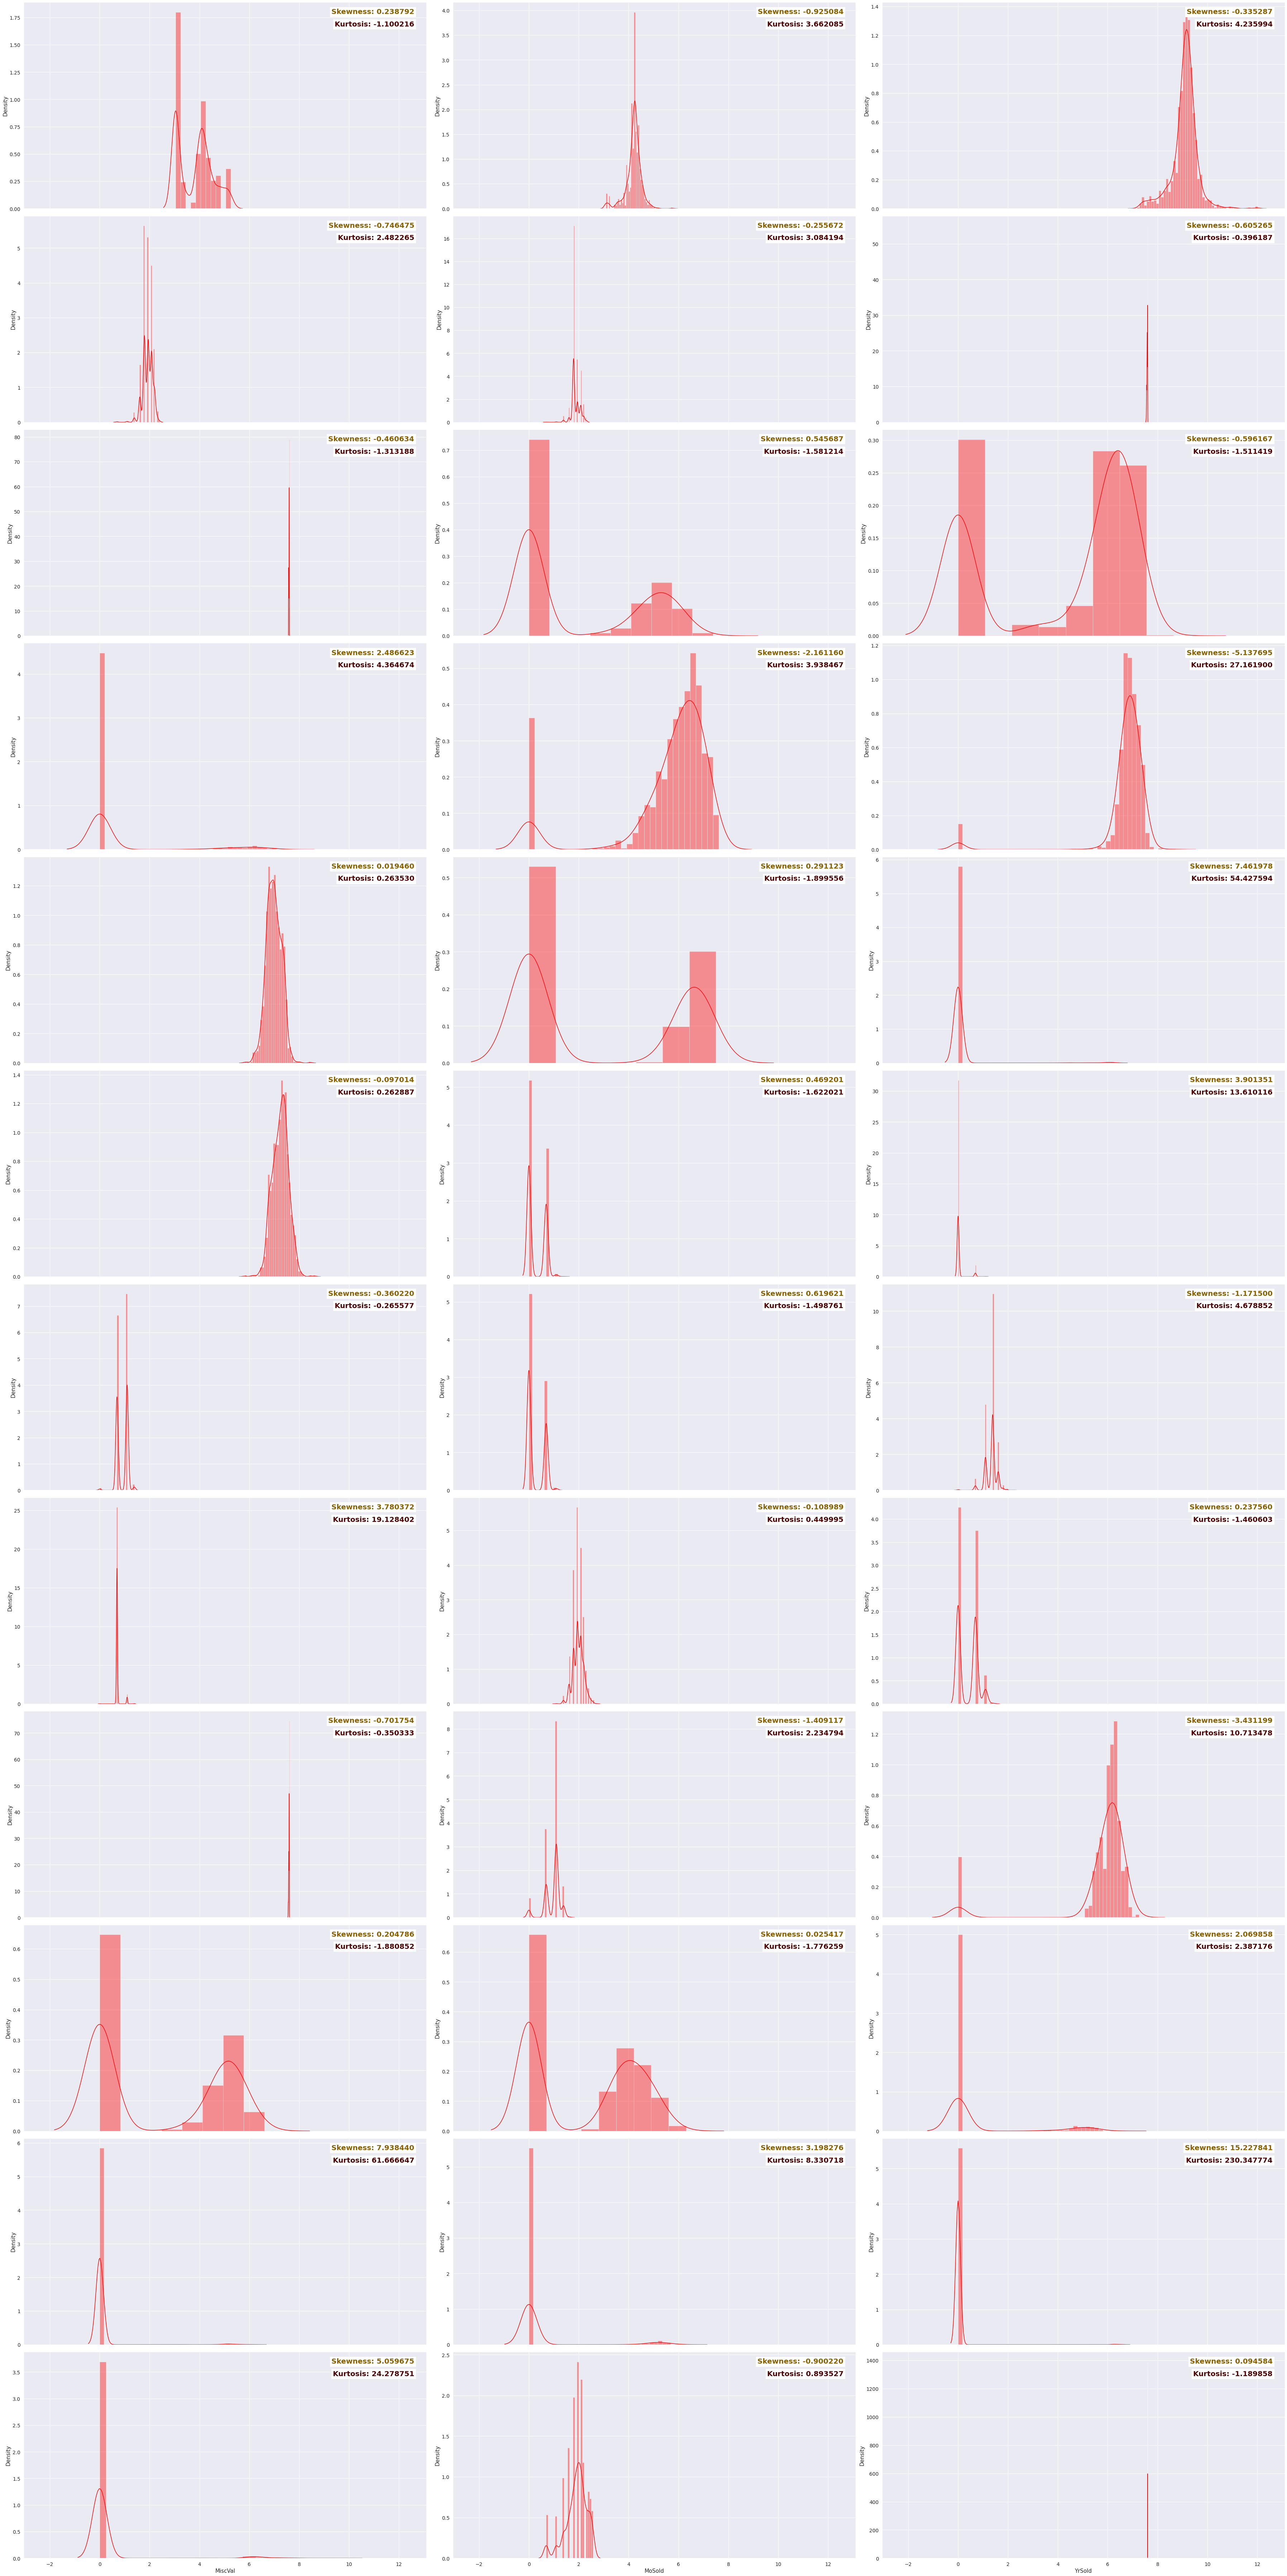

In [122]:
f, axes = plt.subplots(12, 3, figsize=(50, 100), sharex=True)
c = 0
for i in range(12):
  for j in range(3):
    sns.distplot(log_data.iloc[:,c], color="red", ax=axes[i,j])#skyblue
    c+=1
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % log_data.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % log_data.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

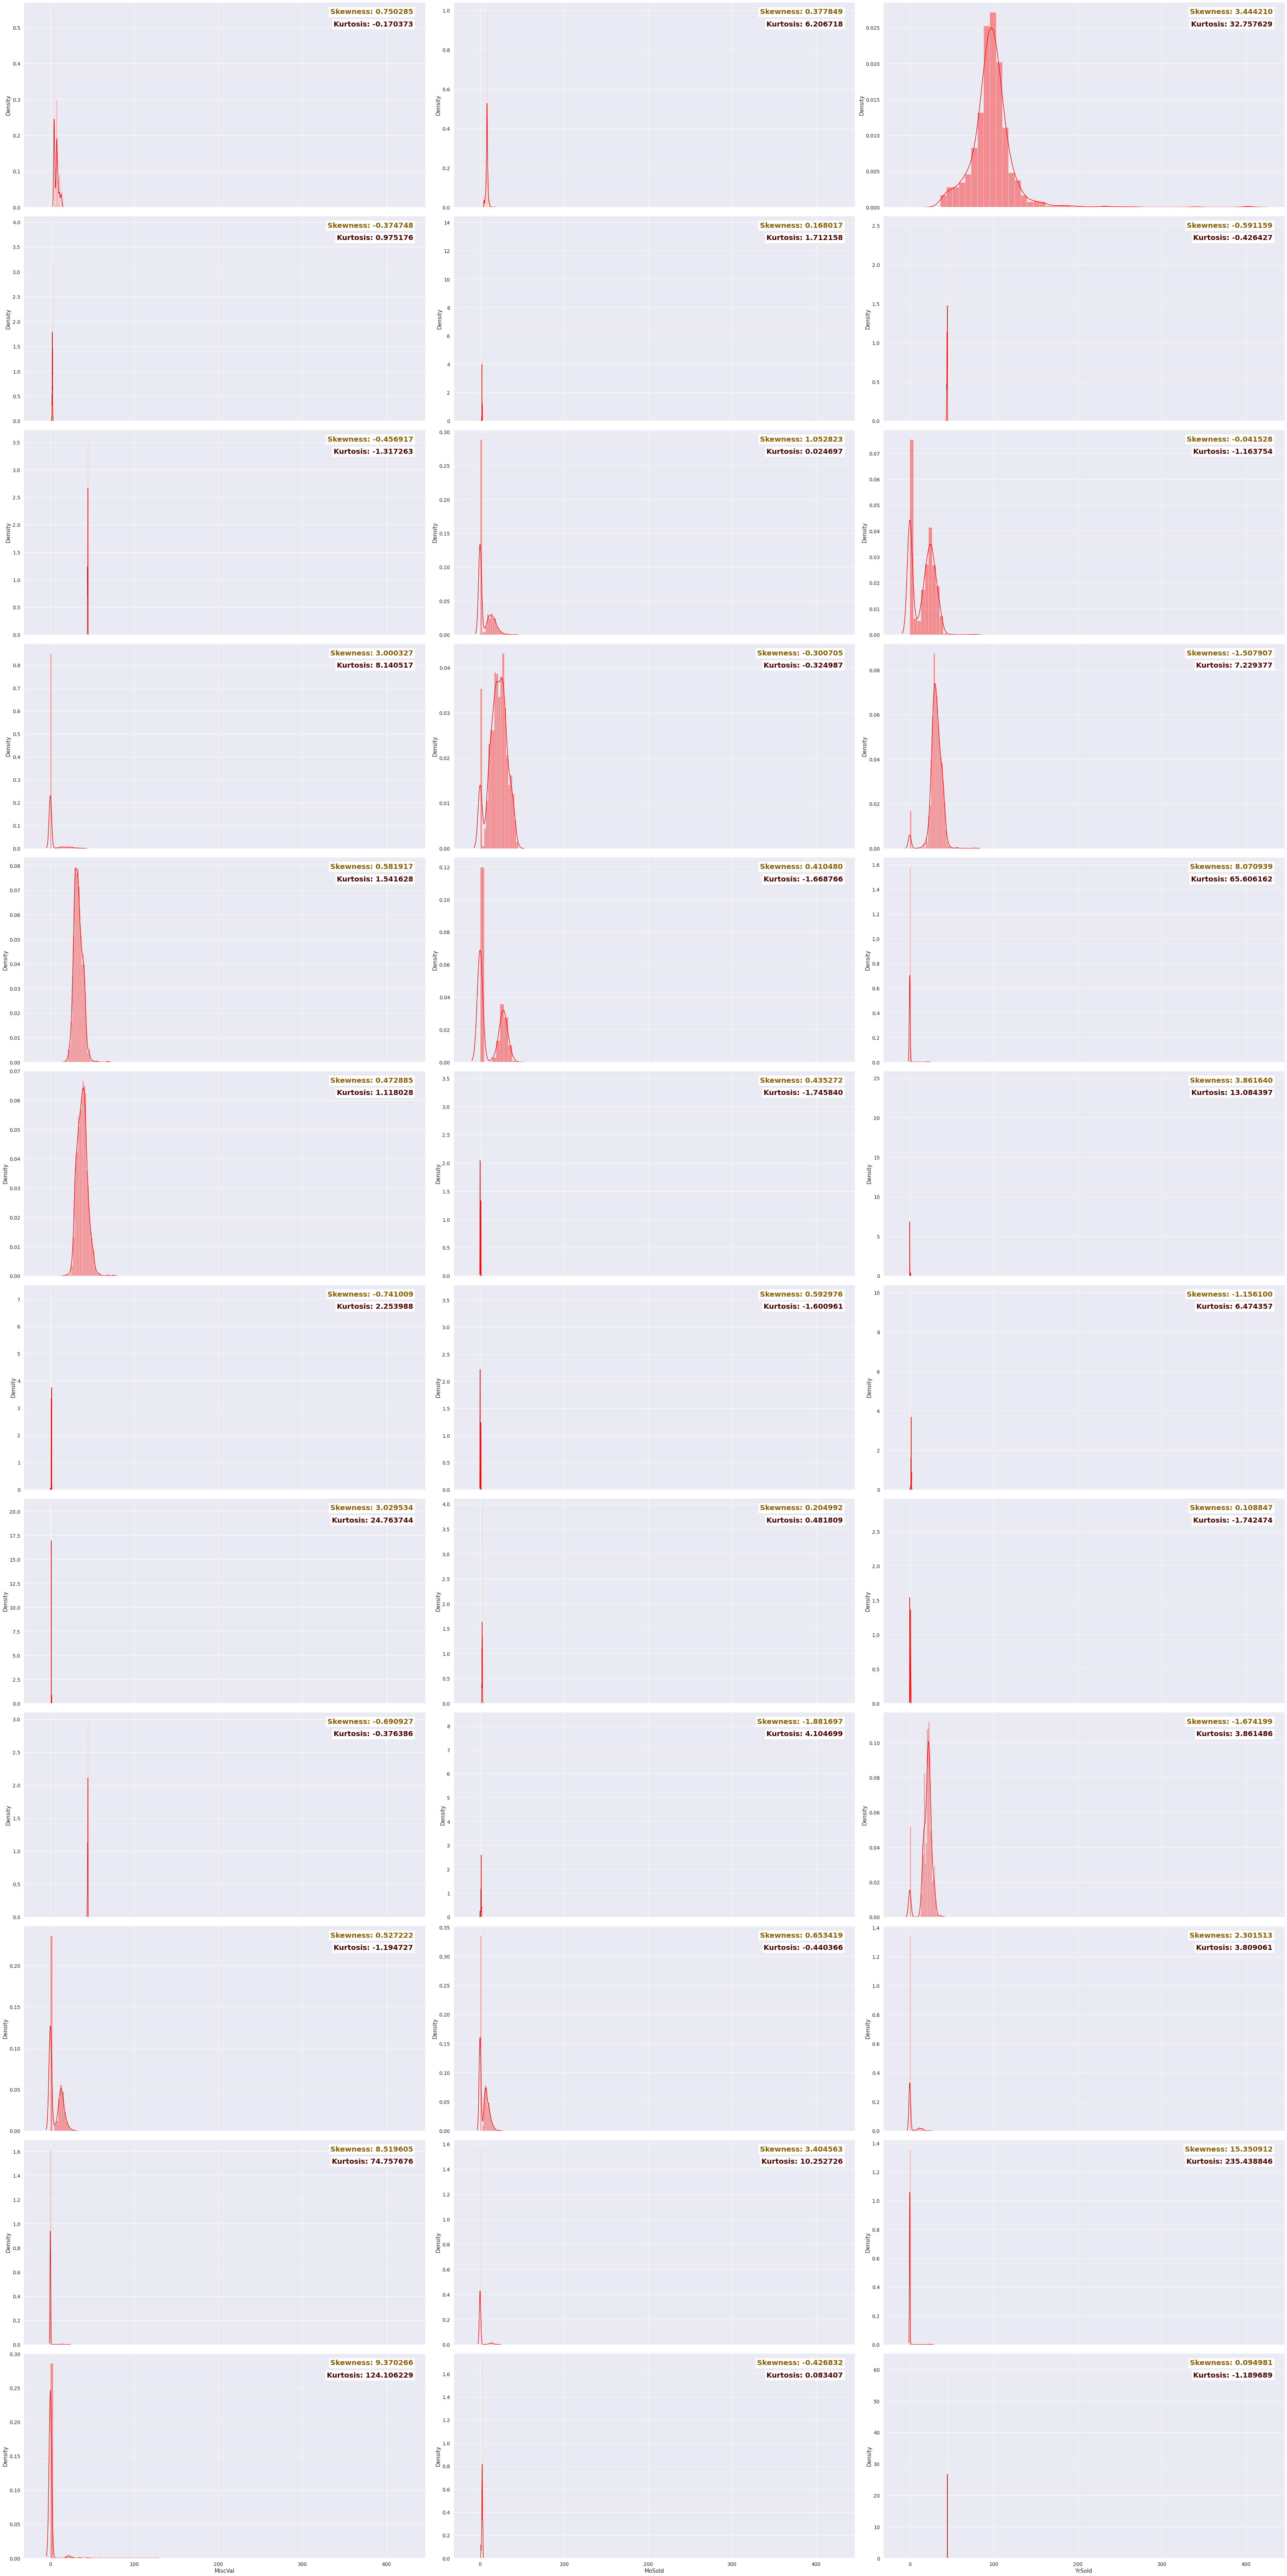

In [123]:
f, axes = plt.subplots(12, 3, figsize=(50, 100), sharex=True)
c = 0
for i in range(12):
  for j in range(3):
    sns.distplot(sqrt_data.iloc[:,c], color="red", ax=axes[i,j])#skyblue
    c+=1
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % sqrt_data.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % sqrt_data.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

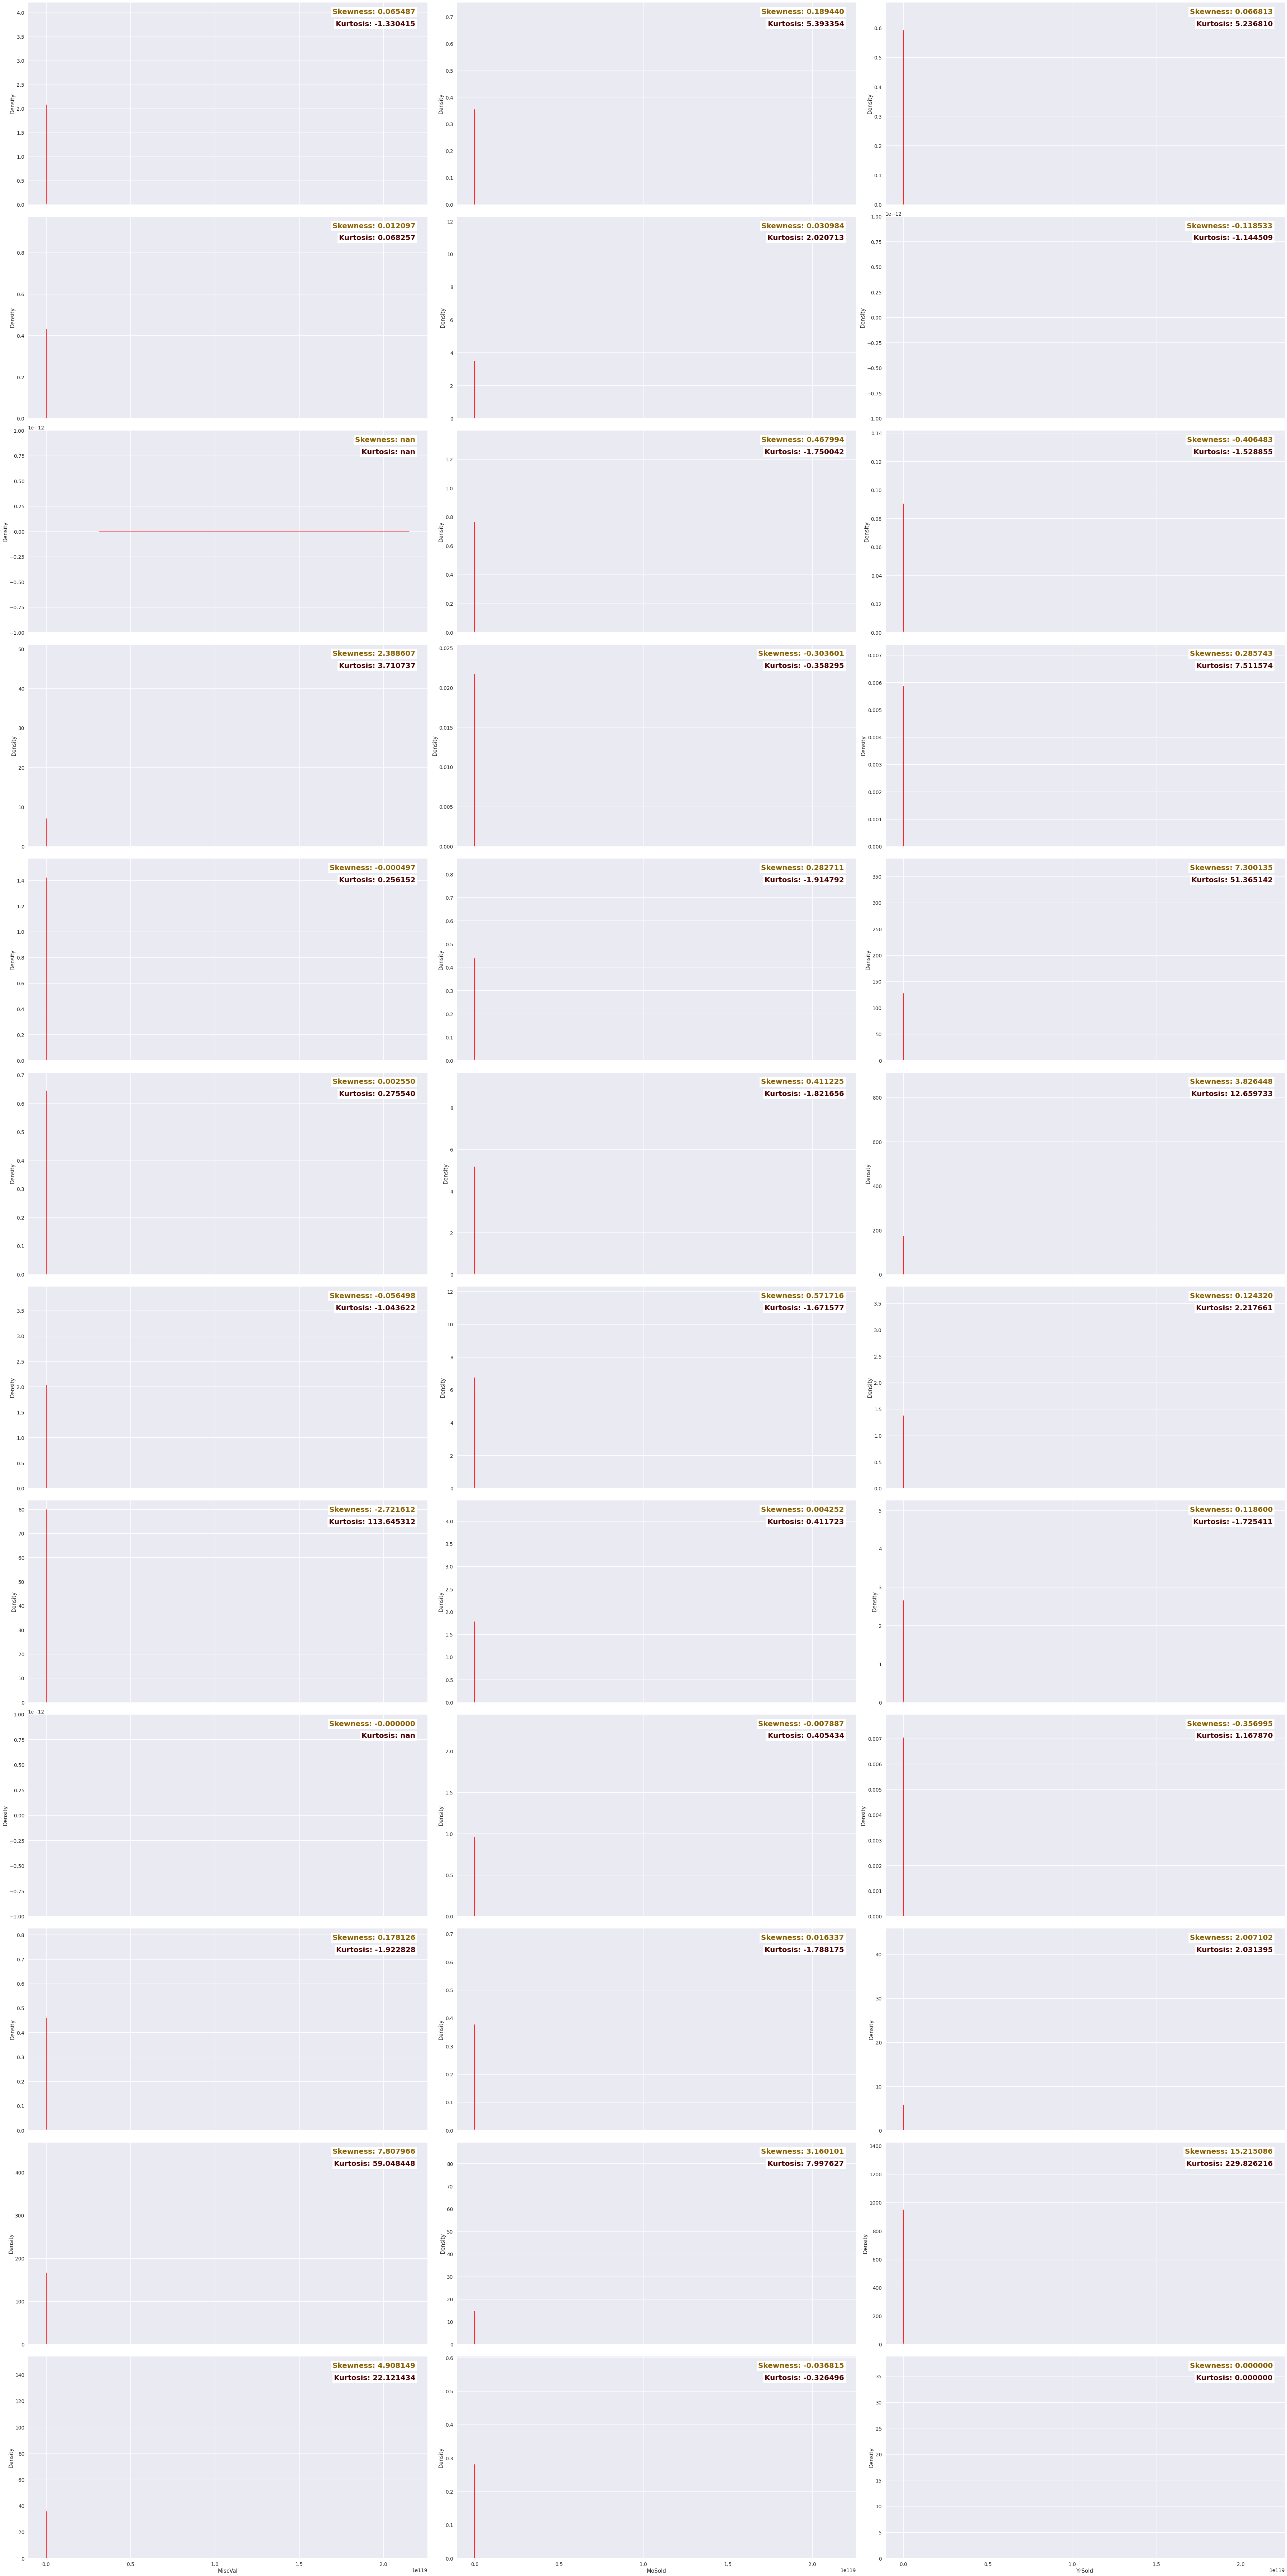

In [124]:
f, axes = plt.subplots(12, 3, figsize=(50, 100), sharex=True)
c = 0
for i in range(12):
  for j in range(3):
    sns.distplot(box_data.iloc[:,c], color="red", ax=axes[i,j])#skyblue
    c+=1
for i, ax in enumerate(axes.reshape(-1)):
    ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % box_data.iloc[:,i].skew(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % box_data.iloc[:,i].kurt(),\
        fontweight='demibold', fontsize=20, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
plt.tight_layout()

<h1>Features Extraction</h1>

In [125]:

features = StandardScaler().fit_transform(tx)
# Create a PCA that will retain 99% of variance
pca = PCA(n_components=0.90, whiten=True)
# Conduct PCA
train = pca.fit_transform(features)
# Show results
print("Original number of features:", features.shape[1])
print("Reduced number of features:", train.shape[1])

Original number of features: 37
Reduced number of features: 23


<h1>Features Selection</h>

In [126]:
# feature selection
def select_features(X, Y, func):
  bestfeatures = SelectKBest(score_func=func, k='all')
  fit = bestfeatures.fit(X,Y)
  return fit,bestfeatures
fit,fs = select_features(tx, tx['SalePrice'], mutual_info_regression)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(tx.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 

mutual_info = featureScores.nlargest(32,'Score')
mutual_info = list(mutual_info['Specs'])
print(len(mutual_info),'\n',mutual_info)
print(featureScores.nlargest(32,'Score'))

32 
 ['SalePrice', 'OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'MSSubClass', 'FullBath', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt', 'LotFrontage', 'TotRmsAbvGrd', '2ndFlrSF', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'OverallCond', 'BsmtFinSF1', 'WoodDeckSF', 'HalfBath', 'BedroomAbvGr', 'MasVnrArea', 'EnclosedPorch', 'BsmtHalfBath', 'ScreenPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'BsmtFullBath', 'MiscVal']
            Specs     Score
36      SalePrice  5.525727
3     OverallQual  0.511781
15      GrLivArea  0.421742
5       YearBuilt  0.338991
26     GarageArea  0.330502
25     GarageCars  0.304040
11    TotalBsmtSF  0.301100
0      MSSubClass  0.275908
18       FullBath  0.244444
12       1stFlrSF  0.240783
6    YearRemodAdd  0.235630
24    GarageYrBlt  0.217429
1     LotFrontage  0.211770
22   TotRmsAbvGrd  0.193401
13       2ndFlrSF  0.192888
23     Fireplaces  0.148288
28    OpenPorchSF  0.145337
2         LotArea  0.136362
10      Bs

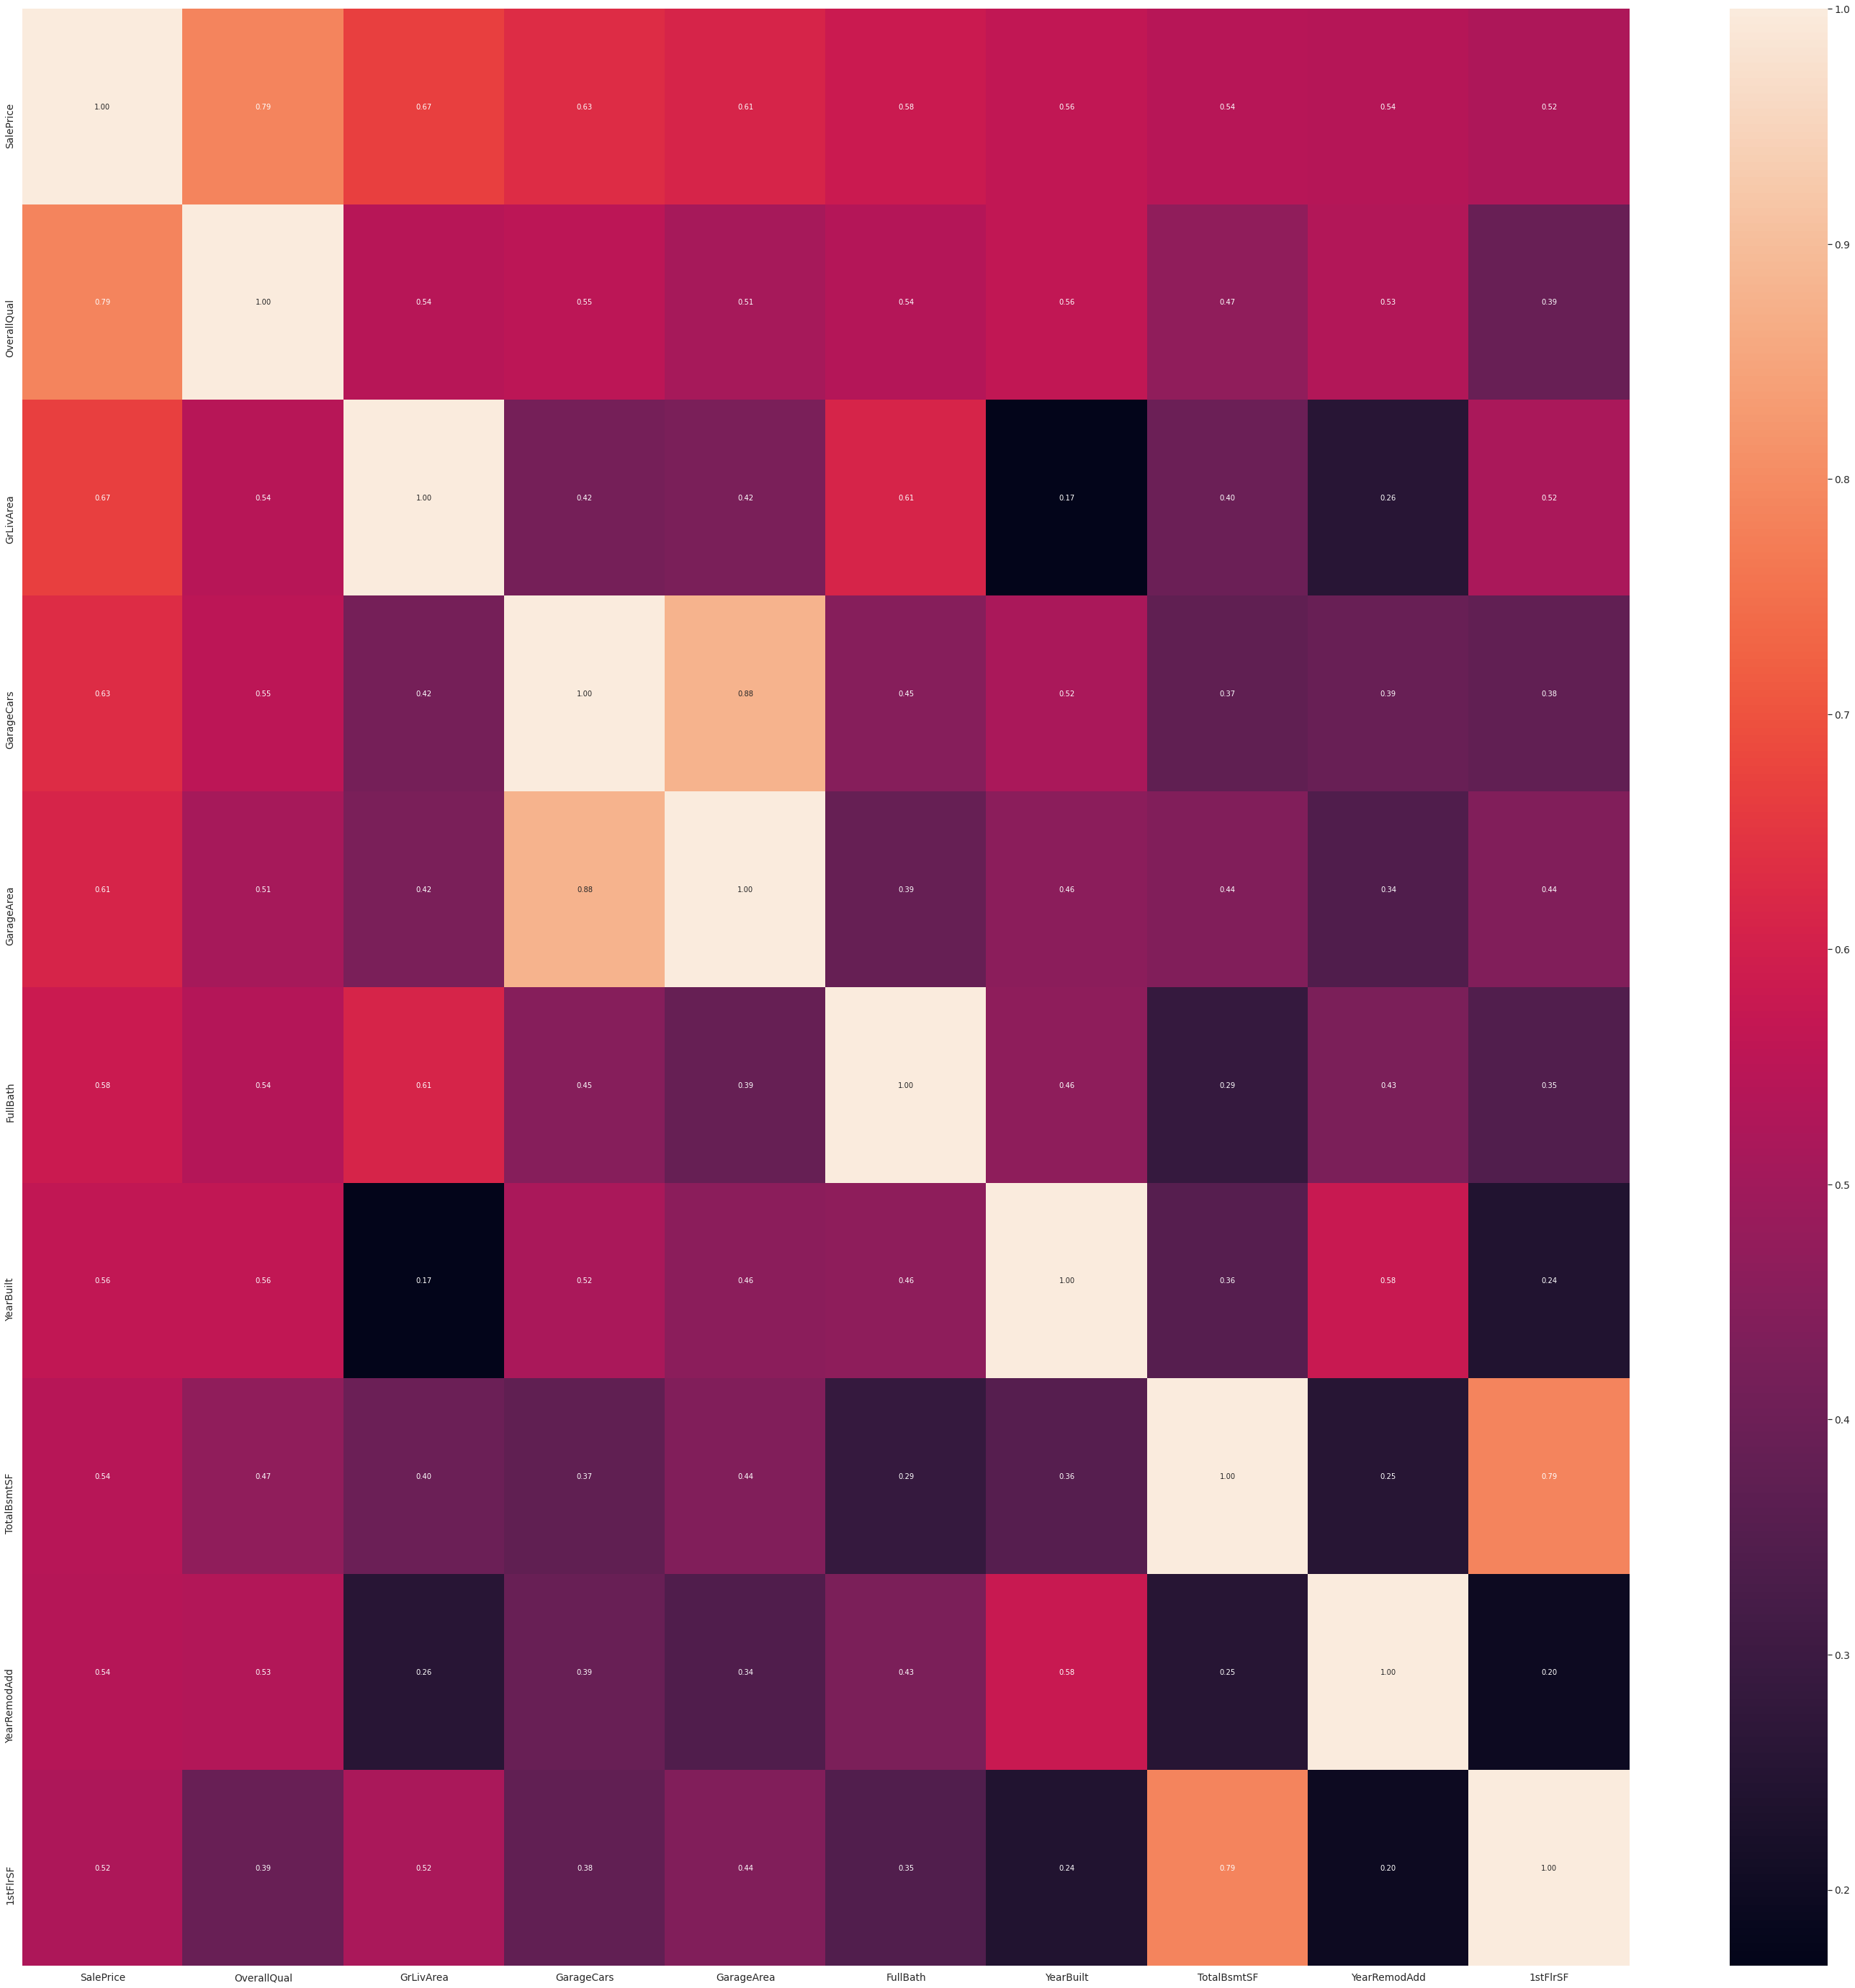

In [127]:
f,ax = plt.subplots(figsize=(50, 50))
corrmat = tx.corr()
k =10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(tx[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=False, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The mean squared error (MSE) on test set: 519544243.9085


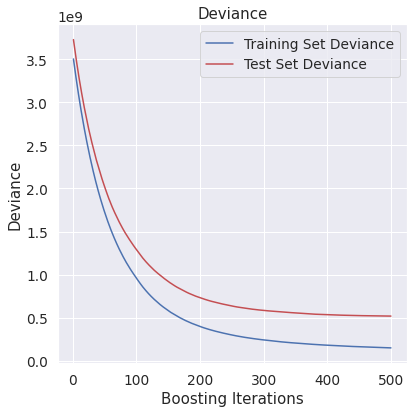

In [128]:

tx1 = tx.copy()
tx1.drop(['SalePrice'],axis=1,inplace=True)
ty1 = tx['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(tx1, ty1, test_size=0.2, random_state=13)

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

'\nresult = permutation_importance(reg, X_test, y_test, n_repeats=10,\n                                random_state=42, n_jobs=2)\nsorted_idx = result.importances_mean.argsort()\nplt.subplot(1, 2, 2)\nplt.boxplot(result.importances[sorted_idx].T,vert=False, labels=np.array(tx.columns)[sorted_idx])\nplt.title("Permutation Importance (test set)")\nfig.tight_layout()\nplt.show() '

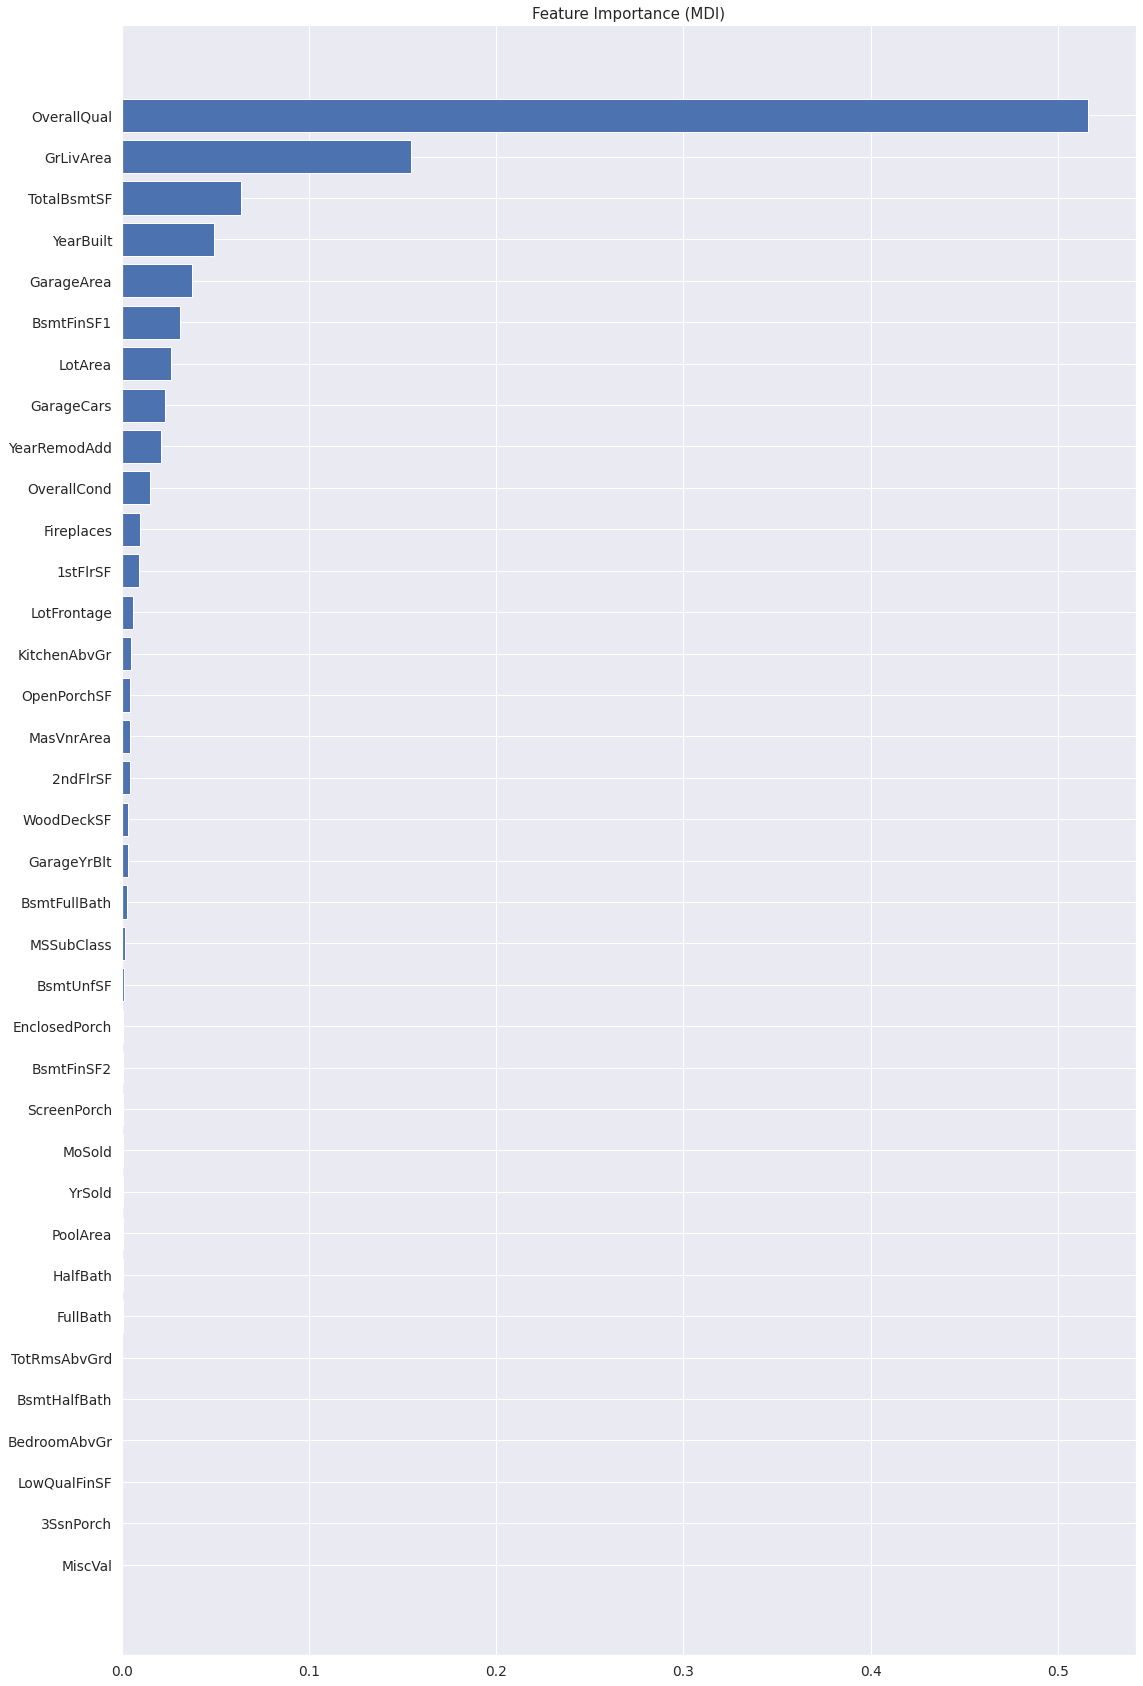

In [129]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#print(pos)
#print(np.array(tx.columns)[sorted_idx])
fig = plt.figure(figsize=(40, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(tx.columns)[sorted_idx])
aa = (pos, np.array(tx.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
'''
result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,vert=False, labels=np.array(tx.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show() '''


<h1>Train & Test</h1>

In [130]:
data_copy = data.copy()
y_c = y.copy()

In [137]:
train = data_copy.iloc[:len(y_c), :]
test = data_copy.iloc[len(train):, :]
Y = np.log1p(y_c)

In [139]:
for i in train:
  if train[i].dtypes != object:
    train[i] = np.log1p(train[i])
    test[i] = np.log1p(test[i])

In [140]:
less_corr = []
for i in train.select_dtypes(exclude=object).columns:
  if train[i].corr(Y) >=.4 or train[i].corr(Y) <=-.4:
    less_corr.append(i)
data_copy.drop(less_corr,axis = 1, inplace = True)
#test.drop(less_corr,axis = 1, inplace = True)

In [141]:
features = pd.get_dummies(data_copy, drop_first=True)

features.shape

(2863, 225)

In [147]:
train = features.iloc[:len(y_c), :]
test = features.iloc[len(train):, :]
Y = np.log1p(y_c)

In [148]:
train.shape, test.shape

((1404, 225), (1459, 225))

In [149]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [150]:
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import os

#print(os.listdir("../input"))

In [151]:
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, Y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return rmse

START ML 2020-10-18 06:44:09.923425


In [ ]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(),
                    SVR(C=20, epsilon=0.008, gamma=0.0003, ))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=42)

lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         # min_data_in_leaf=2,
                         # min_sum_hessian_in_leaf=11
                         )

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

TEST score on CV
Kernel Ridge score: 0.1572 (0.0110)
 2020-10-18 06:44:19.957953
Lasso score: 0.1570 (0.0106)
 2020-10-18 06:44:26.387745
ElasticNet score: 0.1568 (0.0106)
 2020-10-18 06:44:51.056164
SVR score: 0.1471 (0.0197)
 2020-10-18 06:44:57.891722
GradientBoosting score: 0.1299 (0.0146)
 2020-10-18 06:46:09.088470
Lightgbm score: 0.1312 (0.0148)
 2020-10-18 06:46:20.346179
[06:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(train), np.array(Y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(train, Y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(train, Y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(train, Y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(train, Y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(train, Y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(train, Y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(train, Y)


def blend_models_predict(X=train):
    return ((0.1* elastic_model_full_data.predict(X)) + 
            (0.1 * lasso_model_full_data.predict(X)) + 
            (0.05 * ridge_model_full_data.predict(X)) + 
            (0.1 * svr_model_full_data.predict(X)) + 
            (0.1 * gbr_model_full_data.predict(X)) + 
            (0.15 * xgb_model_full_data.predict(X)) + 
            (0.1 * lgb_model_full_data.predict(X)) + 
            (0.3 * stack_gen_model.predict(np.array(X))))


print('RMSLE score on train data:')
print(rmsle(Y, blend_models_predict(train)))
print('MSE score on train data:')
print(mean_squared_error(Y, blend_models_predict(train)))
print('MAE score on train data:')
print(mean_absolute_error(np.expm1(Y), np.floor(np.expm1(blend_models_predict(train)))))

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PassiveAggressiveRegressor


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, Y, test_size=0.1, random_state=1)

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
classifiers = [
    LinearRegression(),
    Ridge(alpha=.9),
    Lasso(alpha=0.1),
    PassiveAggressiveRegressor(max_iter=10000, random_state=0,tol=1e-3),
    SGDRegressor(max_iter=1000, tol=1e-3),
    AdaBoostRegressor(random_state=0, n_estimators=1000,loss='square'),
    GradientBoostingRegressor(**params),
    HistGradientBoostingRegressor(l2_regularization=0, learning_rate=0.1,
                              loss='least_absolute_deviation', max_bins=255,
                              max_depth=15, max_iter=500, max_leaf_nodes=15,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False),
    SVR(C=50, epsilon=0.005, gamma=0.0002, )

]

In [ ]:
  for clf in classifiers:
    clf.fit(X_train,y_train)
    print(clf.__class__.__name__,' ', round(clf.score(X_test, y_test) * 100, 2))
    print(mean_squared_error(y_test, clf.predict(X_test)))
    print()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('poly', 'rbf'), 'C':[7,9],'epsilon':[.007,.008,.01], 'gamma':[.02,.003]}
#model = SVR(C=20, epsilon=0.008, gamma=0.0005, )
clf = GridSearchCV(SVR(), parameters)
scores = cross_val_score(clf, train, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
model = SVR(C=20, epsilon=0.008, gamma=0.0005, )
model.fit(X_train, y_train)
y_pred = model.predict(test)

In [ ]:
y_pred = np.expm1(y_pred)
y_pred

In [ ]:
#y_pred = np.exp(y_pred)
pred_y = y_pred.reshape(-1)
all_id = np.array(test_dataY['Id'])
y_pred = pd.DataFrame(list(zip(all_id, pred_y)),columns =['Id', 'SalePrice'])
y_pred.to_csv("/content/drive/My Drive/MY ML JOURNEY/NoteBook/svr.csv", index=False)